<a href="https://colab.research.google.com/github/thangthao22/python-training/blob/main/Final_%20code_meme_fog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

propoted mthod

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from multiprocessing import Pool
from functools import partial

# ========================
#   THÔNG SỐ MÔ PHỎNG
# ========================
POP_SIZE = 50
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.2
MAX_GENERATIONS = 30
CPU_THRESHOLD = 0.8
RAM_THRESHOLD = 0.9
BANDWIDTH_THRESHOLD = 0.8
PING_TIMEOUT = 5.0
NUM_RUNS = 10
COMMUNICATION_PENALTY = 5.0
OVERLOAD_PENALTY = 150.0
MAX_NEIGHBORS = 5
LOCAL_SEARCH_RATE = 1

# ==========================
#   KỊCH BẢN MÔ PHỎNG
# ==========================
SCENARIOS = [
    {"name": "Basic", "NUM_FOG_NODES": 15, "NUM_TASKS": 600},
    {"name": "High Load", "NUM_FOG_NODES": 15, "NUM_TASKS": 1200},
    {"name": "Scalable Nodes", "NUM_FOG_NODES": 30, "NUM_TASKS": 600},
    {"name": "Critical Overload", "NUM_FOG_NODES": 15, "NUM_TASKS": 600, "OVERLOADED_NODES": 2, "UNRESPONSIVE_NODES": 2}
]

# ========================
#   LỚP MÔ PHỎNG FOG NODE
# ========================
class FogNode:
    def __init__(self, id, cpu_capacity, ram_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity
        self.ram_capacity = ram_capacity
        self.bandwidth = bandwidth
        self.current_cpu_load = 0
        self.current_ram_load = 0
        self.current_tasks = []
        self.is_responsive = True

    def reset_load(self):
        self.current_cpu_load = 0
        self.current_ram_load = 0
        self.current_tasks = []

# ========================
#   LỚP MÔ PHỎNG TASK
# ========================
class Task:
    def __init__(self, id, data_size, processing_time, priority, ram_requirement, network_latency, dependencies=None):
        self.id = id
        self.data_size = data_size              # Kích thước dữ liệu (MB)
        self.processing_time = processing_time  # Thời gian xử lý (giây)
        self.priority = priority                # Mức độ ưu tiên
        self.computation_size = data_size * 10  # Yêu cầu tính toán (MIPS)
        self.ram_requirement = ram_requirement  # Yêu cầu RAM (MB)
        self.network_latency = network_latency  # Độ trễ mạng (giây)
        self.dependencies = dependencies if dependencies else []  # Danh sách ID tác vụ phụ thuộc

# ========================
#   KHỞI TẠO HỆ THỐNG
# ========================
def initialize_system(num_fog_nodes, num_tasks, overloaded_nodes=0, unresponsive_nodes=0):
    cpu_capacity = [random.uniform(2500, 3500) for _ in range(num_fog_nodes)]
    ram_capacity = [random.uniform(4000, 8000) for _ in range(num_fog_nodes)]
    bandwidth = [random.uniform(10, 50) for _ in range(num_fog_nodes)]
    fog_nodes = [FogNode(i, cpu_capacity[i], ram_capacity[i], bandwidth[i]) for i in range(num_fog_nodes)]

    # Mô phỏng nút quá tải và mất kết nối
    for i in range(min(overloaded_nodes, num_fog_nodes)):
        fog_nodes[i].current_cpu_load = fog_nodes[i].cpu_capacity * 1.5
    for i in range(min(unresponsive_nodes, num_fog_nodes)):
        fog_nodes[i].is_responsive = False

    # Khởi tạo tác vụ với các thông số đã điều chỉnh
    tasks = []
    for i in range(num_tasks):
        deps = []  # Bỏ qua phụ thuộc của các tác vụ
        tasks.append(Task(
            id=i,
            data_size=random.uniform(1, 100),          # Từ 1MB đến 100MB
            processing_time=random.uniform(0.0001, 0.01),  # Từ 0.0001 đến 0.01 giây
            priority=random.uniform(0.3, 0.9),         # Mức độ ưu tiên
            ram_requirement=random.uniform(1, 200),    # Từ 1 đến 200 MB
            network_latency=random.uniform(0.001, 0.01),  # Từ 0.001 đến 0.01 giây
            dependencies=deps
        ))
    return fog_nodes, tasks

# ===========================
#   TÍNH TOÁN THỜI GIAN XỬ LÝ
# ===========================
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    latency_time = sum(task.network_latency for task in tasks_assigned)  # Thêm độ trễ mạng
    return processing_time + communication_time + latency_time

# ========================
#   HÀM ĐÁNH GIÁ FITNESS
# ========================
fitness_cache = {}

def fitness_function(solution, fog_nodes, tasks):
    solution_tuple = tuple(solution)
    if solution_tuple in fitness_cache:
        return fitness_cache[solution_tuple]

    for node in fog_nodes:
        node.reset_load()
    fitness = 0
    for task_id, node_id in enumerate(solution):
        task = tasks[task_id]
        node = fog_nodes[node_id]
        node.current_tasks.append(task)
        node.current_cpu_load += task.computation_size
        node.current_ram_load += task.ram_requirement
        # Phạt nếu tác vụ phụ thuộc chưa được xử lý trên cùng nút (không áp dụng vì deps đã bỏ)
        for dep_id in task.dependencies:
            if dep_id not in [t.id for t in node.current_tasks if t != task]:
                fitness += OVERLOAD_PENALTY

    fitness += sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)
    fitness_cache[solution_tuple] = fitness
    return fitness

def compute_fitness(ind, fog_nodes, tasks):
    return fitness_function(ind, fog_nodes, tasks)

# ========================
#   BEST IMPROVEMENT LOCAL SEARCH
# ========================
def best_improvement_local_search(s, fog_nodes, tasks, max_neighbors):
    current_fitness = fitness_function(s, fog_nodes, tasks)
    best_neighbor = s[:]
    best_fitness = current_fitness

    N = []
    for _ in range(max_neighbors):
        neighbor = s[:]
        idx = random.randint(0, len(neighbor) - 1)
        neighbor[idx] = random.randint(0, len(fog_nodes) - 1)
        N.append(neighbor)

    for n in N:
        n_fitness = fitness_function(n, fog_nodes, tasks)
        if n_fitness < best_fitness:
            best_fitness = n_fitness
            best_neighbor = n[:]

    if best_fitness < current_fitness:
        return best_neighbor
    else:
        return s

# ========================
#   HÀM PHÁT HIỆN NÚT QUÁ TẢI HOẶC GẶP VẤN ĐỀ
# ========================
def detect_overloaded_or_problem_nodes(fog_nodes, cpu_threshold, ram_threshold, bandwidth_threshold, ping_timeout):
    overloaded_nodes = []
    problem_nodes = []
    for node in fog_nodes:
        cpu_usage = node.current_cpu_load / node.cpu_capacity if node.cpu_capacity > 0 else 0
        ram_usage = node.current_ram_load / node.ram_capacity if node.ram_capacity > 0 else 0
        bandwidth_usage = sum(task.data_size for task in node.current_tasks) / node.bandwidth if node.bandwidth > 0 else 0

        if (cpu_usage > cpu_threshold or ram_usage > ram_threshold or bandwidth_usage > bandwidth_threshold):
            overloaded_nodes.append(node)
        if not node.is_responsive or (sum(task.processing_time for task in node.current_tasks) > ping_timeout):
            problem_nodes.append(node)

    return overloaded_nodes, problem_nodes

# ========================
#   HÀM TÁI PHÂN BỔ TÁC VỤ
# ========================
def reassign_tasks(solution, fog_nodes, tasks, cpu_threshold, ram_threshold, bandwidth_threshold, ping_timeout):
    overloaded_nodes, problem_nodes = detect_overloaded_or_problem_nodes(fog_nodes, cpu_threshold, ram_threshold, bandwidth_threshold, ping_timeout)

    for node in overloaded_nodes + problem_nodes:
        tasks_to_move = node.current_tasks[:]
        for task in tasks_to_move:
            available_nodes = [n for n in fog_nodes if n != node and n.is_responsive]
            if available_nodes:
                best_node = min(available_nodes, key=lambda n: compute_completion_time(n, n.current_tasks + [task]))
                solution[tasks.index(task)] = best_node.id
                node.current_tasks.remove(task)
                best_node.current_tasks.append(task)

    return solution

# ========================
#   THUẬT TOÁN MEMETIC + REASSIGNMENT
# ========================
def proposed_method(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks, cpu_threshold, ram_threshold, bandwidth_threshold, ping_timeout, max_neighbors):
    population = [[random.randint(0, num_fog_nodes - 1) for _ in range(num_tasks)] for _ in range(popsize)]

    with Pool() as pool:
        fitness_values = pool.map(partial(compute_fitness, fog_nodes=fog_nodes, tasks=tasks), population)

    best_idx = np.argmin(fitness_values)
    best_solution = population[best_idx][:]
    best_fitness = fitness_values[best_idx]

    for _ in range(generations):
        with Pool() as pool:
            fitness_values = pool.map(partial(compute_fitness, fog_nodes=fog_nodes, tasks=tasks), population)

        new_population = [best_solution[:]]
        while len(new_population) < popsize:
            parents = random.choices(population, weights=[1 / (f + 1e-6) for f in fitness_values], k=2)
            parent1, parent2 = parents[0][:], parents[1][:]
            child1, child2 = parent1[:], parent2[:]

            if random.random() < LOCAL_SEARCH_RATE:
                child1 = best_improvement_local_search(child1, fog_nodes, tasks, max_neighbors)
            if random.random() < LOCAL_SEARCH_RATE:
                child2 = best_improvement_local_search(child2, fog_nodes, tasks, max_neighbors)

            new_population.extend([child1, child2])

        population = new_population[:popsize]
        with Pool() as pool:
            fitness_values = pool.map(partial(compute_fitness, fog_nodes=fog_nodes, tasks=tasks), population)

        best_idx = np.argmin(fitness_values)
        current_best = population[best_idx][:]
        current_fitness = fitness_values[best_idx]
        if current_fitness < best_fitness:
            best_solution = current_best[:]
            best_fitness = current_fitness

    best_solution = reassign_tasks(best_solution, fog_nodes, tasks, cpu_threshold, ram_threshold, bandwidth_threshold, ping_timeout)
    best_fitness = fitness_function(best_solution, fog_nodes, tasks)

    return best_fitness

# ========================
#   CHẠY MÔ PHỎNG CHO TẤT CẢ CÁC KỊCH BẢN
# ========================
def run_all_scenarios():
    for scenario in SCENARIOS:
        print(f"\n=== Scenario: {scenario['name']} ===")
        num_fog_nodes = scenario["NUM_FOG_NODES"]
        num_tasks = scenario["NUM_TASKS"]
        overloaded_nodes = scenario.get("OVERLOADED_NODES", 0)
        unresponsive_nodes = scenario.get("UNRESPONSIVE_NODES", 0)

        results = []
        for _ in range(NUM_RUNS):
            fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks, overloaded_nodes, unresponsive_nodes)
            fitness = proposed_method(POP_SIZE, MAX_GENERATIONS, num_fog_nodes, num_tasks,
                                      CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks,
                                      CPU_THRESHOLD, RAM_THRESHOLD, BANDWIDTH_THRESHOLD,
                                      PING_TIMEOUT, MAX_NEIGHBORS)
            results.append(fitness)

        best_fitness = min(results)
        avg_fitness = np.mean(results)
        std_fitness = np.std(results)

        print(f"Best Fitness: {best_fitness:.2f}")
        print(f"Average Fitness: {avg_fitness:.2f}")
        print(f"Standard Deviation: {std_fitness:.2f}")

# ========================
#   CHẠY CHƯƠNG TRÌNH
# ========================
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_all_scenarios()


=== Scenario: Basic ===
Best Fitness: 992.21
Average Fitness: 1090.05
Standard Deviation: 66.68

=== Scenario: High Load ===
Best Fitness: 2050.09
Average Fitness: 2345.05
Standard Deviation: 186.74

=== Scenario: Scalable Nodes ===
Best Fitness: 1015.00
Average Fitness: 1121.92
Standard Deviation: 58.48

=== Scenario: Critical Overload ===
Best Fitness: 1018.11
Average Fitness: 1181.89
Standard Deviation: 105.10


thêm hàm tính thời gian để tính độ phức tạp

In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt
from multiprocessing import Pool
from functools import partial
import time  # Thêm thư viện time để đo thời gian

# ========================
#   THÔNG SỐ MÔ PHỎNG
# ========================
POP_SIZE = 50
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.2
MAX_GENERATIONS = 30
CPU_THRESHOLD = 0.8
RAM_THRESHOLD = 0.9
BANDWIDTH_THRESHOLD = 0.8
PING_TIMEOUT = 5.0
NUM_RUNS = 10
COMMUNICATION_PENALTY = 5.0
OVERLOAD_PENALTY = 150.0
MAX_NEIGHBORS = 5
LOCAL_SEARCH_RATE = 1

# ==========================
#   KỊCH BẢN MÔ PHỎNG
# ==========================
SCENARIOS = [
    {"name": "Basic", "NUM_FOG_NODES": 15, "NUM_TASKS": 600},
    {"name": "High Load", "NUM_FOG_NODES": 15, "NUM_TASKS": 1200},
    {"name": "Scalable Nodes", "NUM_FOG_NODES": 30, "NUM_TASKS": 600},
    {"name": "Critical Overload", "NUM_FOG_NODES": 15, "NUM_TASKS": 600, "OVERLOADED_NODES": 2, "UNRESPONSIVE_NODES": 2}
]

# ========================
#   LỚP MÔ PHỎNG FOG NODE
# ========================
class FogNode:
    def __init__(self, id, cpu_capacity, ram_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity
        self.ram_capacity = ram_capacity
        self.bandwidth = bandwidth
        self.current_cpu_load = 0
        self.current_ram_load = 0
        self.current_tasks = []
        self.is_responsive = True

    def reset_load(self):
        self.current_cpu_load = 0
        self.current_ram_load = 0
        self.current_tasks = []

# ========================
#   LỚP MÔ PHỎNG TASK
# ========================
class Task:
    def __init__(self, id, data_size, processing_time, priority, ram_requirement, network_latency, dependencies=None):
        self.id = id
        self.data_size = data_size              # Kích thước dữ liệu (MB)
        self.processing_time = processing_time  # Thời gian xử lý (giây)
        self.priority = priority                # Mức độ ưu tiên
        self.computation_size = data_size * 10  # Yêu cầu tính toán (MIPS)
        self.ram_requirement = ram_requirement  # Yêu cầu RAM (MB)
        self.network_latency = network_latency  # Độ trễ mạng (giây)
        self.dependencies = dependencies if dependencies else []  # Danh sách ID tác vụ phụ thuộc

# ========================
#   KHỞI TẠO HỆ THỐNG
# ========================
def initialize_system(num_fog_nodes, num_tasks, overloaded_nodes=0, unresponsive_nodes=0):
    cpu_capacity = [random.uniform(2500, 3500) for _ in range(num_fog_nodes)]
    ram_capacity = [random.uniform(4000, 8000) for _ in range(num_fog_nodes)]
    bandwidth = [random.uniform(10, 50) for _ in range(num_fog_nodes)]
    fog_nodes = [FogNode(i, cpu_capacity[i], ram_capacity[i], bandwidth[i]) for i in range(num_fog_nodes)]

    for i in range(min(overloaded_nodes, num_fog_nodes)):
        fog_nodes[i].current_cpu_load = fog_nodes[i].cpu_capacity * 1.5
    for i in range(min(unresponsive_nodes, num_fog_nodes)):
        fog_nodes[i].is_responsive = False

    tasks = []
    for i in range(num_tasks):
        deps = []
        tasks.append(Task(
            id=i,
            data_size=random.uniform(1, 100),
            processing_time=random.uniform(0.0001, 0.01),
            priority=random.uniform(0.3, 0.9),
            ram_requirement=random.uniform(1, 200),
            network_latency=random.uniform(0.001, 0.01),
            dependencies=deps
        ))
    return fog_nodes, tasks

# ===========================
#   TÍNH TOÁN THỜI GIAN XỬ LÝ
# ===========================
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    latency_time = sum(task.network_latency for task in tasks_assigned)
    return processing_time + communication_time + latency_time

# ========================
#   HÀM ĐÁNH GIÁ FITNESS
# ========================
fitness_cache = {}

def fitness_function(solution, fog_nodes, tasks):
    solution_tuple = tuple(solution)
    if solution_tuple in fitness_cache:
        return fitness_cache[solution_tuple]

    for node in fog_nodes:
        node.reset_load()
    fitness = 0
    for task_id, node_id in enumerate(solution):
        task = tasks[task_id]
        node = fog_nodes[node_id]
        node.current_tasks.append(task)
        node.current_cpu_load += task.computation_size
        node.current_ram_load += task.ram_requirement
        for dep_id in task.dependencies:
            if dep_id not in [t.id for t in node.current_tasks if t != task]:
                fitness += OVERLOAD_PENALTY

    fitness += sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)
    fitness_cache[solution_tuple] = fitness
    return fitness

def compute_fitness(ind, fog_nodes, tasks):
    return fitness_function(ind, fog_nodes, tasks)

# ========================
#   BEST IMPROVEMENT LOCAL SEARCH
# ========================
def best_improvement_local_search(s, fog_nodes, tasks, max_neighbors):
    current_fitness = fitness_function(s, fog_nodes, tasks)
    best_neighbor = s[:]
    best_fitness = current_fitness

    N = []
    for _ in range(max_neighbors):
        neighbor = s[:]
        idx = random.randint(0, len(neighbor) - 1)
        neighbor[idx] = random.randint(0, len(fog_nodes) - 1)
        N.append(neighbor)

    for n in N:
        n_fitness = fitness_function(n, fog_nodes, tasks)
        if n_fitness < best_fitness:
            best_fitness = n_fitness
            best_neighbor = n[:]

    if best_fitness < current_fitness:
        return best_neighbor
    else:
        return s

# ========================
#   HÀM PHÁT HIỆN NÚT QUÁ TẢI HOẶC GẶP VẤN ĐỀ
# ========================
def detect_overloaded_or_problem_nodes(fog_nodes, cpu_threshold, ram_threshold, bandwidth_threshold, ping_timeout):
    overloaded_nodes = []
    problem_nodes = []
    for node in fog_nodes:
        cpu_usage = node.current_cpu_load / node.cpu_capacity if node.cpu_capacity > 0 else 0
        ram_usage = node.current_ram_load / node.ram_capacity if node.ram_capacity > 0 else 0
        bandwidth_usage = sum(task.data_size for task in node.current_tasks) / node.bandwidth if node.bandwidth > 0 else 0

        if (cpu_usage > cpu_threshold or ram_usage > ram_threshold or bandwidth_usage > bandwidth_threshold):
            overloaded_nodes.append(node)
        if not node.is_responsive or (sum(task.processing_time for task in node.current_tasks) > ping_timeout):
            problem_nodes.append(node)

    return overloaded_nodes, problem_nodes

# ========================
#   HÀM TÁI PHÂN BỔ TÁC VỤ
# ========================
def reassign_tasks(solution, fog_nodes, tasks, cpu_threshold, ram_threshold, bandwidth_threshold, ping_timeout):
    overloaded_nodes, problem_nodes = detect_overloaded_or_problem_nodes(fog_nodes, cpu_threshold, ram_threshold, bandwidth_threshold, ping_timeout)

    for node in overloaded_nodes + problem_nodes:
        tasks_to_move = node.current_tasks[:]
        for task in tasks_to_move:
            available_nodes = [n for n in fog_nodes if n != node and n.is_responsive]
            if available_nodes:
                best_node = min(available_nodes, key=lambda n: compute_completion_time(n, n.current_tasks + [task]))
                solution[tasks.index(task)] = best_node.id
                node.current_tasks.remove(task)
                best_node.current_tasks.append(task)

    return solution

# ========================
#   THUẬT TOÁN MEMETIC + REASSIGNMENT
# ========================
def proposed_method(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks, cpu_threshold, ram_threshold, bandwidth_threshold, ping_timeout, max_neighbors):
    population = [[random.randint(0, num_fog_nodes - 1) for _ in range(num_tasks)] for _ in range(popsize)]

    with Pool() as pool:
        fitness_values = pool.map(partial(compute_fitness, fog_nodes=fog_nodes, tasks=tasks), population)

    best_idx = np.argmin(fitness_values)
    best_solution = population[best_idx][:]
    best_fitness = fitness_values[best_idx]

    for _ in range(generations):
        with Pool() as pool:
            fitness_values = pool.map(partial(compute_fitness, fog_nodes=fog_nodes, tasks=tasks), population)

        new_population = [best_solution[:]]
        while len(new_population) < popsize:
            parents = random.choices(population, weights=[1 / (f + 1e-6) for f in fitness_values], k=2)
            parent1, parent2 = parents[0][:], parents[1][:]
            child1, child2 = parent1[:], parent2[:]

            if random.random() < LOCAL_SEARCH_RATE:
                child1 = best_improvement_local_search(child1, fog_nodes, tasks, max_neighbors)
            if random.random() < LOCAL_SEARCH_RATE:
                child2 = best_improvement_local_search(child2, fog_nodes, tasks, max_neighbors)

            new_population.extend([child1, child2])

        population = new_population[:popsize]
        with Pool() as pool:
            fitness_values = pool.map(partial(compute_fitness, fog_nodes=fog_nodes, tasks=tasks), population)

        best_idx = np.argmin(fitness_values)
        current_best = population[best_idx][:]
        current_fitness = fitness_values[best_idx]
        if current_fitness < best_fitness:
            best_solution = current_best[:]
            best_fitness = current_fitness

    best_solution = reassign_tasks(best_solution, fog_nodes, tasks, cpu_threshold, ram_threshold, bandwidth_threshold, ping_timeout)
    best_fitness = fitness_function(best_solution, fog_nodes, tasks)

    return best_fitness

# ========================
#   CHẠY MÔ PHỎNG CHO TẤT CẢ CÁC KỊCH BẢN
# ========================
def run_all_scenarios():
    for scenario in SCENARIOS:
        print(f"\n=== Scenario: {scenario['name']} ===")
        num_fog_nodes = scenario["NUM_FOG_NODES"]
        num_tasks = scenario["NUM_TASKS"]
        overloaded_nodes = scenario.get("OVERLOADED_NODES", 0)
        unresponsive_nodes = scenario.get("UNRESPONSIVE_NODES", 0)

        results = []  # Danh sách lưu fitness
        run_times = []  # Danh sách lưu thời gian chạy

        for _ in range(NUM_RUNS):
            fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks, overloaded_nodes, unresponsive_nodes)

            # Đo thời gian chạy của thuật toán
            start_time = time.time()
            fitness = proposed_method(
                POP_SIZE, MAX_GENERATIONS, num_fog_nodes, num_tasks,
                CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks,
                CPU_THRESHOLD, RAM_THRESHOLD, BANDWIDTH_THRESHOLD,
                PING_TIMEOUT, MAX_NEIGHBORS
            )
            end_time = time.time()

            # Lưu kết quả
            run_time = end_time - start_time
            results.append(fitness)
            run_times.append(run_time)

        # Tính toán các chỉ số fitness
        best_fitness = min(results)
        avg_fitness = np.mean(results)
        std_fitness = np.std(results)

        # Tính toán các chỉ số thời gian
        min_time = min(run_times)
        avg_time = np.mean(run_times)
        max_time = max(run_times)

        # In kết quả
        print(f"Best Fitness: {best_fitness:.2f}")
        print(f"Average Fitness: {avg_fitness:.2f}")
        print(f"Standard Deviation (Fitness): {std_fitness:.2f}")
        print(f"Min Runtime: {min_time:.4f} seconds")
        print(f"Average Runtime: {avg_time:.4f} seconds")
        print(f"Max Runtime: {max_time:.4f} seconds")

# ========================
#   CHẠY CHƯƠNG TRÌNH
# ========================
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_all_scenarios()


=== Scenario: Basic ===
Best Fitness: 992.21
Average Fitness: 1090.05
Standard Deviation (Fitness): 66.68
Min Runtime: 18.3722 seconds
Average Runtime: 19.2744 seconds
Max Runtime: 19.9078 seconds

=== Scenario: High Load ===
Best Fitness: 2050.09
Average Fitness: 2345.05
Standard Deviation (Fitness): 186.74
Min Runtime: 26.2739 seconds
Average Runtime: 30.0432 seconds
Max Runtime: 46.8195 seconds

=== Scenario: Scalable Nodes ===
Best Fitness: 1015.00
Average Fitness: 1121.92
Standard Deviation (Fitness): 58.48
Min Runtime: 20.0590 seconds
Average Runtime: 23.2498 seconds
Max Runtime: 36.9196 seconds

=== Scenario: Critical Overload ===
Best Fitness: 1018.11
Average Fitness: 1181.89
Standard Deviation (Fitness): 105.10
Min Runtime: 19.8183 seconds
Average Runtime: 20.5594 seconds
Max Runtime: 21.1248 seconds


MÔ PHỎNG VỚI GA

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from multiprocessing import Pool
from functools import partial

# ========================
#   THÔNG SỐ MÔ PHỎNG
# ========================
POP_SIZE = 50
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.2
MAX_GENERATIONS = 30
CPU_THRESHOLD = 0.8
RAM_THRESHOLD = 0.9
BANDWIDTH_THRESHOLD = 0.8
PING_TIMEOUT = 5.0
NUM_RUNS = 10
COMMUNICATION_PENALTY = 5.0
OVERLOAD_PENALTY = 150.0

# ==========================
#   KỊCH BẢN MÔ PHỎNG
# ==========================
SCENARIOS = [
    {"name": "Basic", "NUM_FOG_NODES": 15, "NUM_TASKS": 600},
    {"name": "High Load", "NUM_FOG_NODES": 15, "NUM_TASKS": 1200},
    {"name": "Scalable Nodes", "NUM_FOG_NODES": 30, "NUM_TASKS": 600},
    {"name": "Critical Overload", "NUM_FOG_NODES": 15, "NUM_TASKS": 600, "OVERLOADED_NODES": 2, "UNRESPONSIVE_NODES": 2}
]

# ========================
#   LỚP MÔ PHỎNG FOG NODE
# ========================
class FogNode:
    def __init__(self, id, cpu_capacity, ram_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity
        self.ram_capacity = ram_capacity
        self.bandwidth = bandwidth
        self.current_cpu_load = 0
        self.current_ram_load = 0
        self.current_tasks = []
        self.is_responsive = True

    def reset_load(self):
        self.current_cpu_load = 0
        self.current_ram_load = 0
        self.current_tasks = []

# ========================
#   LỚP MÔ PHỎNG TASK
# ========================
class Task:
    def __init__(self, id, data_size, processing_time, priority, ram_requirement, network_latency, dependencies=None):
        self.id = id
        self.data_size = data_size              # Kích thước dữ liệu (MB)
        self.processing_time = processing_time  # Thời gian xử lý (giây)
        self.priority = priority                # Mức độ ưu tiên
        self.computation_size = data_size * 10  # Yêu cầu tính toán (MIPS)
        self.ram_requirement = ram_requirement  # Yêu cầu RAM (MB)
        self.network_latency = network_latency  # Độ trễ mạng (giây)
        self.dependencies = dependencies if dependencies else []  # Danh sách ID tác vụ phụ thuộc

# ========================
#   KHỞI TẠO HỆ THỐNG
# ========================
def initialize_system(num_fog_nodes, num_tasks, overloaded_nodes=0, unresponsive_nodes=0):
    cpu_capacity = [random.uniform(2500, 3500) for _ in range(num_fog_nodes)]
    ram_capacity = [random.uniform(4000, 8000) for _ in range(num_fog_nodes)]
    bandwidth = [random.uniform(10, 50) for _ in range(num_fog_nodes)]
    fog_nodes = [FogNode(i, cpu_capacity[i], ram_capacity[i], bandwidth[i]) for i in range(num_fog_nodes)]

    # Mô phỏng nút quá tải và mất kết nối (chỉ khởi tạo, không tái phân bổ)
    for i in range(min(overloaded_nodes, num_fog_nodes)):
        fog_nodes[i].current_cpu_load = fog_nodes[i].cpu_capacity * 1.5
    for i in range(min(unresponsive_nodes, num_fog_nodes)):
        fog_nodes[i].is_responsive = False

    # Khởi tạo tác vụ với các thông số đã điều chỉnh
    tasks = []
    for i in range(num_tasks):
        deps = []  # Bỏ qua phụ thuộc của các tác vụ
        tasks.append(Task(
            id=i,
            data_size=random.uniform(1, 100),          # Từ 1MB đến 100MB
            processing_time=random.uniform(0.0001, 0.01),  # Từ 0.0001 đến 0.01 giây
            priority=random.uniform(0.3, 0.9),         # Mức độ ưu tiên
            ram_requirement=random.uniform(1, 200),    # Từ 1 đến 200 MB
            network_latency=random.uniform(0.001, 0.01),  # Từ 0.001 đến 0.01 giây
            dependencies=deps
        ))
    return fog_nodes, tasks

# ===========================
#   TÍNH TOÁN THỜI GIAN XỬ LÝ
# ===========================
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    latency_time = sum(task.network_latency for task in tasks_assigned)  # Thêm độ trễ mạng
    return processing_time + communication_time + latency_time

# ========================
#   HÀM ĐÁNH GIÁ FITNESS
# ========================
fitness_cache = {}

def fitness_function(solution, fog_nodes, tasks):
    solution_tuple = tuple(solution)
    if solution_tuple in fitness_cache:
        return fitness_cache[solution_tuple]

    for node in fog_nodes:
        node.reset_load()
    fitness = 0
    for task_id, node_id in enumerate(solution):
        task = tasks[task_id]
        node = fog_nodes[node_id]
        node.current_tasks.append(task)
        node.current_cpu_load += task.computation_size
        node.current_ram_load += task.ram_requirement
        # Phạt nếu tác vụ phụ thuộc chưa được xử lý trên cùng nút (không áp dụng vì deps đã bỏ)
        for dep_id in task.dependencies:
            if dep_id not in [t.id for t in node.current_tasks if t != task]:
                fitness += OVERLOAD_PENALTY

    fitness += sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)
    fitness_cache[solution_tuple] = fitness
    return fitness

def compute_fitness(ind, fog_nodes, tasks):
    return fitness_function(ind, fog_nodes, tasks)

# ========================
#   THUẬT TOÁN GA
# ========================
def proposed_method(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks):
    # Khởi tạo quần thể
    population = [[random.randint(0, num_fog_nodes - 1) for _ in range(num_tasks)] for _ in range(popsize)]

    for generation in range(generations):
        # Tính fitness cho từng cá thể
        with Pool() as pool:
            fitness_values = pool.map(partial(compute_fitness, fog_nodes=fog_nodes, tasks=tasks), population)

        # Chọn cá thể tốt nhất hiện tại
        best_idx = np.argmin(fitness_values)
        best_solution = population[best_idx][:]
        best_fitness = fitness_values[best_idx]

        # Tạo quần thể mới
        new_population = [best_solution[:]]  # Elitism: giữ lại giải pháp tốt nhất

        while len(new_population) < popsize:
            # Chọn bố mẹ bằng phương pháp Roulette Selection
            weights = [1 / (f + 1e-6) for f in fitness_values]
            total_weight = sum(weights)
            weights = [w / total_weight for w in weights]
            parent1 = random.choices(population, weights=weights, k=1)[0][:]
            parent2 = random.choices(population, weights=weights, k=1)[0][:]

            # Lai ghép (Crossover)
            if random.random() < pcrossover:
                point = random.randint(1, len(parent1) - 2)
                child1 = parent1[:point] + parent2[point:]
                child2 = parent2[:point] + parent1[point:]
            else:
                child1, child2 = parent1[:], parent2[:]

            # Đột biến (Mutation)
            child1 = [random.randint(0, num_fog_nodes - 1) if random.random() < pmutation else gene for gene in child1]
            child2 = [random.randint(0, num_fog_nodes - 1) if random.random() < pmutation else gene for gene in child2]

            new_population.extend([child1, child2])

        population = new_population[:popsize]

    # Chọn giải pháp tốt nhất sau khi GA kết thúc
    with Pool() as pool:
        fitness_values = pool.map(partial(compute_fitness, fog_nodes=fog_nodes, tasks=tasks), population)
    best_idx = np.argmin(fitness_values)
    best_solution = population[best_idx][:]
    best_fitness = fitness_function(best_solution, fog_nodes, tasks)

    return best_fitness

# ========================
#   CHẠY MÔ PHỎNG CHO TẤT CẢ CÁC KỊCH BẢN
# ========================
def run_all_scenarios():
    for scenario in SCENARIOS:
        print(f"\n=== Scenario: {scenario['name']} ===")
        num_fog_nodes = scenario["NUM_FOG_NODES"]
        num_tasks = scenario["NUM_TASKS"]
        overloaded_nodes = scenario.get("OVERLOADED_NODES", 0)
        unresponsive_nodes = scenario.get("UNRESPONSIVE_NODES", 0)

        results = []
        for _ in range(NUM_RUNS):
            fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks, overloaded_nodes, unresponsive_nodes)
            fitness = proposed_method(POP_SIZE, MAX_GENERATIONS, num_fog_nodes, num_tasks,
                                      CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks)
            results.append(fitness)

        best_fitness = min(results)
        avg_fitness = np.mean(results)
        std_fitness = np.std(results)

        print(f"Best Fitness: {best_fitness:.2f}")
        print(f"Average Fitness: {avg_fitness:.2f}")
        print(f"Standard Deviation: {std_fitness:.2f}")

# ========================
#   CHẠY CHƯƠNG TRÌNH
# ========================
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_all_scenarios()


=== Scenario: Basic ===
Best Fitness: 1080.69
Average Fitness: 1236.59
Standard Deviation: 153.83

=== Scenario: High Load ===
Best Fitness: 2213.12
Average Fitness: 2659.03
Standard Deviation: 278.29

=== Scenario: Scalable Nodes ===
Best Fitness: 1140.18
Average Fitness: 1240.99
Standard Deviation: 74.05

=== Scenario: Critical Overload ===
Best Fitness: 1106.88
Average Fitness: 1280.19
Standard Deviation: 113.69


thêm hàm tính thời gian

In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt
from multiprocessing import Pool
from functools import partial
import time  # Thêm thư viện time để đo thời gian

# ========================
#   THÔNG SỐ MÔ PHỎNG
# ========================
POP_SIZE = 50
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.2
MAX_GENERATIONS = 30
CPU_THRESHOLD = 0.8
RAM_THRESHOLD = 0.9
BANDWIDTH_THRESHOLD = 0.8
PING_TIMEOUT = 5.0
NUM_RUNS = 10
COMMUNICATION_PENALTY = 5.0
OVERLOAD_PENALTY = 150.0

# ==========================
#   KỊCH BẢN MÔ PHỎNG
# ==========================
SCENARIOS = [
    {"name": "Basic", "NUM_FOG_NODES": 15, "NUM_TASKS": 600},
    {"name": "High Load", "NUM_FOG_NODES": 15, "NUM_TASKS": 1200},
    {"name": "Scalable Nodes", "NUM_FOG_NODES": 30, "NUM_TASKS": 600},
    {"name": "Critical Overload", "NUM_FOG_NODES": 15, "NUM_TASKS": 600, "OVERLOADED_NODES": 2, "UNRESPONSIVE_NODES": 2}
]

# ========================
#   LỚP MÔ PHỎNG FOG NODE
# ========================
class FogNode:
    def __init__(self, id, cpu_capacity, ram_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity
        self.ram_capacity = ram_capacity
        self.bandwidth = bandwidth
        self.current_cpu_load = 0
        self.current_ram_load = 0
        self.current_tasks = []
        self.is_responsive = True

    def reset_load(self):
        self.current_cpu_load = 0
        self.current_ram_load = 0
        self.current_tasks = []

# ========================
#   LỚP MÔ PHỎNG TASK
# ========================
class Task:
    def __init__(self, id, data_size, processing_time, priority, ram_requirement, network_latency, dependencies=None):
        self.id = id
        self.data_size = data_size              # Kích thước dữ liệu (MB)
        self.processing_time = processing_time  # Thời gian xử lý (giây)
        self.priority = priority                # Mức độ ưu tiên
        self.computation_size = data_size * 10  # Yêu cầu tính toán (MIPS)
        self.ram_requirement = ram_requirement  # Yêu cầu RAM (MB)
        self.network_latency = network_latency  # Độ trễ mạng (giây)
        self.dependencies = dependencies if dependencies else []  # Danh sách ID tác vụ phụ thuộc

# ========================
#   KHỞI TẠO HỆ THỐNG
# ========================
def initialize_system(num_fog_nodes, num_tasks, overloaded_nodes=0, unresponsive_nodes=0):
    cpu_capacity = [random.uniform(2500, 3500) for _ in range(num_fog_nodes)]
    ram_capacity = [random.uniform(4000, 8000) for _ in range(num_fog_nodes)]
    bandwidth = [random.uniform(10, 50) for _ in range(num_fog_nodes)]
    fog_nodes = [FogNode(i, cpu_capacity[i], ram_capacity[i], bandwidth[i]) for i in range(num_fog_nodes)]

    for i in range(min(overloaded_nodes, num_fog_nodes)):
        fog_nodes[i].current_cpu_load = fog_nodes[i].cpu_capacity * 1.5
    for i in range(min(unresponsive_nodes, num_fog_nodes)):
        fog_nodes[i].is_responsive = False

    tasks = []
    for i in range(num_tasks):
        deps = []
        tasks.append(Task(
            id=i,
            data_size=random.uniform(1, 100),
            processing_time=random.uniform(0.0001, 0.01),
            priority=random.uniform(0.3, 0.9),
            ram_requirement=random.uniform(1, 200),
            network_latency=random.uniform(0.001, 0.01),
            dependencies=deps
        ))
    return fog_nodes, tasks

# ===========================
#   TÍNH TOÁN THỜI GIAN XỬ LÝ
# ===========================
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    latency_time = sum(task.network_latency for task in tasks_assigned)
    return processing_time + communication_time + latency_time

# ========================
#   HÀM ĐÁNH GIÁ FITNESS
# ========================
fitness_cache = {}

def fitness_function(solution, fog_nodes, tasks):
    solution_tuple = tuple(solution)
    if solution_tuple in fitness_cache:
        return fitness_cache[solution_tuple]

    for node in fog_nodes:
        node.reset_load()
    fitness = 0
    for task_id, node_id in enumerate(solution):
        task = tasks[task_id]
        node = fog_nodes[node_id]
        node.current_tasks.append(task)
        node.current_cpu_load += task.computation_size
        node.current_ram_load += task.ram_requirement
        for dep_id in task.dependencies:
            if dep_id not in [t.id for t in node.current_tasks if t != task]:
                fitness += OVERLOAD_PENALTY

    fitness += sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)
    fitness_cache[solution_tuple] = fitness
    return fitness

def compute_fitness(ind, fog_nodes, tasks):
    return fitness_function(ind, fog_nodes, tasks)

# ========================
#   THUẬT TOÁN GA
# ========================
def proposed_method(popsize, generations, num_fog_nodes, num_tasks, pcrossover, pmutation, fog_nodes, tasks):
    population = [[random.randint(0, num_fog_nodes - 1) for _ in range(num_tasks)] for _ in range(popsize)]

    for generation in range(generations):
        with Pool() as pool:
            fitness_values = pool.map(partial(compute_fitness, fog_nodes=fog_nodes, tasks=tasks), population)

        best_idx = np.argmin(fitness_values)
        best_solution = population[best_idx][:]
        best_fitness = fitness_values[best_idx]

        new_population = [best_solution[:]]
        while len(new_population) < popsize:
            weights = [1 / (f + 1e-6) for f in fitness_values]
            total_weight = sum(weights)
            weights = [w / total_weight for w in weights]
            parent1 = random.choices(population, weights=weights, k=1)[0][:]
            parent2 = random.choices(population, weights=weights, k=1)[0][:]

            if random.random() < pcrossover:
                point = random.randint(1, len(parent1) - 2)
                child1 = parent1[:point] + parent2[point:]
                child2 = parent2[:point] + parent1[point:]
            else:
                child1, child2 = parent1[:], parent2[:]

            child1 = [random.randint(0, num_fog_nodes - 1) if random.random() < pmutation else gene for gene in child1]
            child2 = [random.randint(0, num_fog_nodes - 1) if random.random() < pmutation else gene for gene in child2]

            new_population.extend([child1, child2])

        population = new_population[:popsize]

    with Pool() as pool:
        fitness_values = pool.map(partial(compute_fitness, fog_nodes=fog_nodes, tasks=tasks), population)
    best_idx = np.argmin(fitness_values)
    best_solution = population[best_idx][:]
    best_fitness = fitness_function(best_solution, fog_nodes, tasks)

    return best_fitness

# ========================
#   CHẠY MÔ PHỎNG CHO TẤT CẢ CÁC KỊCH BẢN
# ========================
def run_all_scenarios():
    for scenario in SCENARIOS:
        print(f"\n=== Scenario: {scenario['name']} ===")
        num_fog_nodes = scenario["NUM_FOG_NODES"]
        num_tasks = scenario["NUM_TASKS"]
        overloaded_nodes = scenario.get("OVERLOADED_NODES", 0)
        unresponsive_nodes = scenario.get("UNRESPONSIVE_NODES", 0)

        results = []  # Danh sách lưu fitness
        run_times = []  # Danh sách lưu thời gian chạy

        for _ in range(NUM_RUNS):
            fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks, overloaded_nodes, unresponsive_nodes)

            # Đo thời gian chạy của thuật toán
            start_time = time.time()
            fitness = proposed_method(
                POP_SIZE, MAX_GENERATIONS, num_fog_nodes, num_tasks,
                CROSSOVER_RATE, MUTATION_RATE, fog_nodes, tasks
            )
            end_time = time.time()

            # Lưu kết quả
            run_time = end_time - start_time
            results.append(fitness)
            run_times.append(run_time)

        # Tính toán các chỉ số fitness
        best_fitness = min(results)
        avg_fitness = np.mean(results)
        std_fitness = np.std(results)

        # Tính toán các chỉ số thời gian
        min_time = min(run_times)
        avg_time = np.mean(run_times)
        max_time = max(run_times)

        # In kết quả
        print(f"Best Fitness: {best_fitness:.2f}")
        print(f"Average Fitness: {avg_fitness:.2f}")
        print(f"Standard Deviation (Fitness): {std_fitness:.2f}")
        print(f"Min Runtime: {min_time:.4f} seconds")
        print(f"Average Runtime: {avg_time:.4f} seconds")
        print(f"Max Runtime: {max_time:.4f} seconds")

# ========================
#   CHẠY CHƯƠNG TRÌNH
# ========================
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_all_scenarios()


=== Scenario: Basic ===
Best Fitness: 1080.69
Average Fitness: 1236.59
Standard Deviation (Fitness): 153.83
Min Runtime: 7.1921 seconds
Average Runtime: 9.0827 seconds
Max Runtime: 14.9664 seconds

=== Scenario: High Load ===
Best Fitness: 2213.12
Average Fitness: 2659.03
Standard Deviation (Fitness): 278.29
Min Runtime: 8.9032 seconds
Average Runtime: 10.1466 seconds
Max Runtime: 11.8754 seconds

=== Scenario: Scalable Nodes ===
Best Fitness: 1140.18
Average Fitness: 1240.99
Standard Deviation (Fitness): 74.05
Min Runtime: 7.6244 seconds
Average Runtime: 10.1273 seconds
Max Runtime: 16.1596 seconds

=== Scenario: Critical Overload ===
Best Fitness: 1106.88
Average Fitness: 1280.19
Standard Deviation (Fitness): 113.69
Min Runtime: 7.8783 seconds
Average Runtime: 9.4314 seconds
Max Runtime: 15.5792 seconds


RR

In [3]:
import numpy as np
import random

# ========================
#   THÔNG SỐ MÔ PHỎNG
# ========================
CPU_THRESHOLD = 0.8
NUM_RUNS = 10
COMMUNICATION_PENALTY = 5.0
OVERLOAD_PENALTY = 150.0

# ==========================
#   KỊCH BẢN MÔ PHỎNG
# ==========================
SCENARIOS = [
    {"name": "Basic", "NUM_FOG_NODES": 15, "NUM_TASKS": 600},
    {"name": "High Load", "NUM_FOG_NODES": 15, "NUM_TASKS": 1200},
    {"name": "Scalable Nodes", "NUM_FOG_NODES": 30, "NUM_TASKS": 600},
    {"name": "Critical Overload", "NUM_FOG_NODES": 15, "NUM_TASKS": 600, "OVERLOADED_NODES": 2, "UNRESPONSIVE_NODES": 2}
]

# ========================
#   LỚP MÔ PHỎNG FOG NODE
# ========================
class FogNode:
    def __init__(self, id, cpu_capacity, ram_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity
        self.ram_capacity = ram_capacity
        self.bandwidth = bandwidth
        self.current_cpu_load = 0
        self.current_ram_load = 0
        self.current_tasks = []
        self.is_responsive = True

    def reset_load(self):
        self.current_cpu_load = 0
        self.current_ram_load = 0
        self.current_tasks = []

# ========================
#   LỚP MÔ PHỎNG TASK
# ========================
class Task:
    def __init__(self, id, data_size, processing_time, priority, ram_requirement, network_latency, dependencies=None):
        self.id = id
        self.data_size = data_size              # Kích thước dữ liệu (MB)
        self.processing_time = processing_time  # Thời gian xử lý (giây)
        self.priority = priority                # Mức độ ưu tiên
        self.computation_size = data_size * 10  # Yêu cầu tính toán (MIPS)
        self.ram_requirement = ram_requirement  # Yêu cầu RAM (MB)
        self.network_latency = network_latency  # Độ trễ mạng (giây)
        self.dependencies = dependencies if dependencies else []  # Danh sách ID tác vụ phụ thuộc

# ========================
#   KHỞI TẠO HỆ THỐNG
# ========================
def initialize_system(num_fog_nodes, num_tasks, overloaded_nodes=0, unresponsive_nodes=0):
    cpu_capacity = [random.uniform(2500, 3500) for _ in range(num_fog_nodes)]
    ram_capacity = [random.uniform(4000, 8000) for _ in range(num_fog_nodes)]
    bandwidth = [random.uniform(10, 50) for _ in range(num_fog_nodes)]
    fog_nodes = [FogNode(i, cpu_capacity[i], ram_capacity[i], bandwidth[i]) for i in range(num_fog_nodes)]

    # Mô phỏng nút quá tải và mất kết nối
    for i in range(min(overloaded_nodes, num_fog_nodes)):
        fog_nodes[i].current_cpu_load = fog_nodes[i].cpu_capacity * 1.5
    for i in range(min(unresponsive_nodes, num_fog_nodes)):
        fog_nodes[i].is_responsive = False

    # Khởi tạo danh sách tác vụ
    tasks = []
    for i in range(num_tasks):
        tasks.append(Task(
            id=i,
            data_size=random.uniform(1, 100),          # Từ 1MB đến 100MB
            processing_time=random.uniform(0.0001, 0.01),  # Từ 0.0001 đến 0.01 giây
            priority=random.uniform(0.3, 0.9),         # Mức độ ưu tiên
            ram_requirement=random.uniform(1, 200),    # Từ 1 đến 200 MB
            network_latency=random.uniform(0.001, 0.01),  # Từ 0.001 đến 0.01 giây
            dependencies=[]  # Không có phụ thuộc
        ))
    return fog_nodes, tasks

# ===========================
#   TÍNH TOÁN THỜI GIAN XỬ LÝ
# ===========================
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    latency_time = sum(task.network_latency for task in tasks_assigned)
    return processing_time + communication_time + latency_time

# ========================
#   HÀM ĐÁNH GIÁ FITNESS
# ========================
def fitness_function(solution, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
    fitness = 0
    for task_id, node_id in enumerate(solution):
        task = tasks[task_id]
        node = fog_nodes[node_id]
        node.current_tasks.append(task)
        node.current_cpu_load += task.computation_size
        node.current_ram_load += task.ram_requirement

    fitness += sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)
    return fitness

# ========================
#   THUẬT TOÁN ROUND-ROBIN
# ========================
def round_robin_assignment(tasks, fog_nodes):
    num_fog_nodes = len(fog_nodes)
    solution = [-1] * len(tasks)
    node_index = 0

    for task in tasks:
        assigned = False
        attempts = 0

        while not assigned and attempts < num_fog_nodes:
            node = fog_nodes[node_index]
            cpu_usage = (node.current_cpu_load + task.computation_size) / node.cpu_capacity

            if cpu_usage <= CPU_THRESHOLD:
                solution[task.id] = node.id
                node.current_tasks.append(task)
                node.current_cpu_load += task.computation_size
                assigned = True

            node_index = (node_index + 1) % num_fog_nodes
            attempts += 1

        if not assigned:
            best_node = min(fog_nodes, key=lambda n: n.current_cpu_load / n.cpu_capacity)
            solution[task.id] = best_node.id
            best_node.current_tasks.append(task)
            best_node.current_cpu_load += task.computation_size

    return solution

# ========================
#   CHẠY MÔ PHỎNG CHO TẤT CẢ CÁC KỊCH BẢN
# ========================
def run_all_scenarios():
    for scenario in SCENARIOS:
        print(f"\n=== Scenario: {scenario['name']} ===")
        num_fog_nodes = scenario["NUM_FOG_NODES"]
        num_tasks = scenario["NUM_TASKS"]
        overloaded_nodes = scenario.get("OVERLOADED_NODES", 0)
        unresponsive_nodes = scenario.get("UNRESPONSIVE_NODES", 0)

        results = []
        for _ in range(NUM_RUNS):
            fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks, overloaded_nodes, unresponsive_nodes)

            # Áp dụng Round-Robin để phân bổ tác vụ
            solution = round_robin_assignment(tasks, fog_nodes)

            # Tính fitness cho giải pháp từ RR
            fitness = fitness_function(solution, fog_nodes, tasks)
            results.append(fitness)

        best_fitness = min(results)
        avg_fitness = np.mean(results)
        std_fitness = np.std(results)

        print(f"Best Fitness: {best_fitness:.2f}")
        print(f"Average Fitness: {avg_fitness:.2f}")
        print(f"Standard Deviation: {std_fitness:.2f}")

# ========================
#   CHẠY CHƯƠNG TRÌNH
# ========================
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_all_scenarios()


=== Scenario: Basic ===
Best Fitness: 1155.36
Average Fitness: 1367.24
Standard Deviation: 143.75

=== Scenario: High Load ===
Best Fitness: 2072.54
Average Fitness: 2698.88
Standard Deviation: 328.16

=== Scenario: Scalable Nodes ===
Best Fitness: 1185.76
Average Fitness: 1301.15
Standard Deviation: 85.06

=== Scenario: Critical Overload ===
Best Fitness: 1078.15
Average Fitness: 1278.68
Standard Deviation: 115.34


thêm hàm tính thời gian

In [8]:
import numpy as np
import random
import time  # Thêm thư viện time để đo thời gian

# ========================
#   THÔNG SỐ MÔ PHỎNG
# ========================
CPU_THRESHOLD = 0.8
NUM_RUNS = 10
COMMUNICATION_PENALTY = 5.0
OVERLOAD_PENALTY = 150.0

# ==========================
#   KỊCH BẢN MÔ PHỎNG
# ==========================
SCENARIOS = [
    {"name": "Basic", "NUM_FOG_NODES": 15, "NUM_TASKS": 600},
    {"name": "High Load", "NUM_FOG_NODES": 15, "NUM_TASKS": 1200},
    {"name": "Scalable Nodes", "NUM_FOG_NODES": 30, "NUM_TASKS": 600},
    {"name": "Critical Overload", "NUM_FOG_NODES": 15, "NUM_TASKS": 600, "OVERLOADED_NODES": 2, "UNRESPONSIVE_NODES": 2}
]

# ========================
#   LỚP MÔ PHỎNG FOG NODE
# ========================
class FogNode:
    def __init__(self, id, cpu_capacity, ram_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity
        self.ram_capacity = ram_capacity
        self.bandwidth = bandwidth
        self.current_cpu_load = 0
        self.current_ram_load = 0
        self.current_tasks = []
        self.is_responsive = True

    def reset_load(self):
        self.current_cpu_load = 0
        self.current_ram_load = 0
        self.current_tasks = []

# ========================
#   LỚP MÔ PHỎNG TASK
# ========================
class Task:
    def __init__(self, id, data_size, processing_time, priority, ram_requirement, network_latency, dependencies=None):
        self.id = id
        self.data_size = data_size              # Kích thước dữ liệu (MB)
        self.processing_time = processing_time  # Thời gian xử lý (giây)
        self.priority = priority                # Mức độ ưu tiên
        self.computation_size = data_size * 10  # Yêu cầu tính toán (MIPS)
        self.ram_requirement = ram_requirement  # Yêu cầu RAM (MB)
        self.network_latency = network_latency  # Độ trễ mạng (giây)
        self.dependencies = dependencies if dependencies else []  # Danh sách ID tác vụ phụ thuộc

# ========================
#   KHỞI TẠO HỆ THỐNG
# ========================
def initialize_system(num_fog_nodes, num_tasks, overloaded_nodes=0, unresponsive_nodes=0):
    cpu_capacity = [random.uniform(2500, 3500) for _ in range(num_fog_nodes)]
    ram_capacity = [random.uniform(4000, 8000) for _ in range(num_fog_nodes)]
    bandwidth = [random.uniform(10, 50) for _ in range(num_fog_nodes)]
    fog_nodes = [FogNode(i, cpu_capacity[i], ram_capacity[i], bandwidth[i]) for i in range(num_fog_nodes)]

    for i in range(min(overloaded_nodes, num_fog_nodes)):
        fog_nodes[i].current_cpu_load = fog_nodes[i].cpu_capacity * 1.5
    for i in range(min(unresponsive_nodes, num_fog_nodes)):
        fog_nodes[i].is_responsive = False

    tasks = []
    for i in range(num_tasks):
        tasks.append(Task(
            id=i,
            data_size=random.uniform(1, 100),
            processing_time=random.uniform(0.0001, 0.01),
            priority=random.uniform(0.3, 0.9),
            ram_requirement=random.uniform(1, 200),
            network_latency=random.uniform(0.001, 0.01),
            dependencies=[]
        ))
    return fog_nodes, tasks

# ===========================
#   TÍNH TOÁN THỜI GIAN XỬ LÝ
# ===========================
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    latency_time = sum(task.network_latency for task in tasks_assigned)
    return processing_time + communication_time + latency_time

# ========================
#   HÀM ĐÁNH GIÁ FITNESS
# ========================
def fitness_function(solution, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
    fitness = 0
    for task_id, node_id in enumerate(solution):
        task = tasks[task_id]
        node = fog_nodes[node_id]
        node.current_tasks.append(task)
        node.current_cpu_load += task.computation_size
        node.current_ram_load += task.ram_requirement

    fitness += sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)
    return fitness

# ========================
#   THUẬT TOÁN ROUND-ROBIN
# ========================
def round_robin_assignment(tasks, fog_nodes):
    num_fog_nodes = len(fog_nodes)
    solution = [-1] * len(tasks)
    node_index = 0

    for task in tasks:
        assigned = False
        attempts = 0

        while not assigned and attempts < num_fog_nodes:
            node = fog_nodes[node_index]
            cpu_usage = (node.current_cpu_load + task.computation_size) / node.cpu_capacity

            if cpu_usage <= CPU_THRESHOLD:
                solution[task.id] = node.id
                node.current_tasks.append(task)
                node.current_cpu_load += task.computation_size
                assigned = True

            node_index = (node_index + 1) % num_fog_nodes
            attempts += 1

        if not assigned:
            best_node = min(fog_nodes, key=lambda n: n.current_cpu_load / n.cpu_capacity)
            solution[task.id] = best_node.id
            best_node.current_tasks.append(task)
            best_node.current_cpu_load += task.computation_size

    return solution

# ========================
#   CHẠY MÔ PHỎNG CHO TẤT CẢ CÁC KỊCH BẢN
# ========================
def run_all_scenarios():
    for scenario in SCENARIOS:
        print(f"\n=== Scenario: {scenario['name']} ===")
        num_fog_nodes = scenario["NUM_FOG_NODES"]
        num_tasks = scenario["NUM_TASKS"]
        overloaded_nodes = scenario.get("OVERLOADED_NODES", 0)
        unresponsive_nodes = scenario.get("UNRESPONSIVE_NODES", 0)

        results = []  # Danh sách lưu fitness
        run_times = []  # Danh sách lưu thời gian chạy

        for _ in range(NUM_RUNS):
            fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks, overloaded_nodes, unresponsive_nodes)

            # Đo thời gian chạy của thuật toán Round-Robin
            start_time = time.time()
            solution = round_robin_assignment(tasks, fog_nodes)
            fitness = fitness_function(solution, fog_nodes, tasks)
            end_time = time.time()

            # Lưu kết quả
            run_time = end_time - start_time
            results.append(fitness)
            run_times.append(run_time)

        # Tính toán các chỉ số fitness
        best_fitness = min(results)
        avg_fitness = np.mean(results)
        std_fitness = np.std(results)

        # Tính toán các chỉ số thời gian
        min_time = min(run_times)
        avg_time = np.mean(run_times)
        max_time = max(run_times)

        # In kết quả
        print(f"Best Fitness: {best_fitness:.2f}")
        print(f"Average Fitness: {avg_fitness:.2f}")
        print(f"Standard Deviation (Fitness): {std_fitness:.2f}")
        print(f"Min Runtime: {min_time:.4f} seconds")
        print(f"Average Runtime: {avg_time:.4f} seconds")
        print(f"Max Runtime: {max_time:.4f} seconds")

# ========================
#   CHẠY CHƯƠNG TRÌNH
# ========================
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_all_scenarios()


=== Scenario: Basic ===
Best Fitness: 1155.36
Average Fitness: 1367.24
Standard Deviation (Fitness): 143.75
Min Runtime: 0.0023 seconds
Average Runtime: 0.0027 seconds
Max Runtime: 0.0037 seconds

=== Scenario: High Load ===
Best Fitness: 2072.54
Average Fitness: 2698.88
Standard Deviation (Fitness): 328.16
Min Runtime: 0.0048 seconds
Average Runtime: 0.0051 seconds
Max Runtime: 0.0058 seconds

=== Scenario: Scalable Nodes ===
Best Fitness: 1185.76
Average Fitness: 1301.15
Standard Deviation (Fitness): 85.06
Min Runtime: 0.0034 seconds
Average Runtime: 0.0040 seconds
Max Runtime: 0.0052 seconds

=== Scenario: Critical Overload ===
Best Fitness: 1078.15
Average Fitness: 1278.68
Standard Deviation (Fitness): 115.34
Min Runtime: 0.0023 seconds
Average Runtime: 0.0024 seconds
Max Runtime: 0.0030 seconds


Thuật toán Greedy

In [9]:
import numpy as np
import random

# ========================
#   THÔNG SỐ MÔ PHỎNG
# ========================
CPU_THRESHOLD = 0.8
NUM_RUNS = 10
COMMUNICATION_PENALTY = 5.0
OVERLOAD_PENALTY = 150.0

# ==========================
#   KỊCH BẢN MÔ PHỎNG
# ==========================
SCENARIOS = [
    {"name": "Basic", "NUM_FOG_NODES": 15, "NUM_TASKS": 600},
    {"name": "High Load", "NUM_FOG_NODES": 15, "NUM_TASKS": 1200},
    {"name": "Scalable Nodes", "NUM_FOG_NODES": 30, "NUM_TASKS": 600},
    {"name": "Critical Overload", "NUM_FOG_NODES": 15, "NUM_TASKS": 600, "OVERLOADED_NODES": 2, "UNRESPONSIVE_NODES": 2}
]

# ========================
#   LỚP MÔ PHỎNG FOG NODE
# ========================
class FogNode:
    def __init__(self, id, cpu_capacity, ram_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity
        self.ram_capacity = ram_capacity
        self.bandwidth = bandwidth
        self.current_cpu_load = 0
        self.current_ram_load = 0
        self.current_tasks = []
        self.is_responsive = True

    def reset_load(self):
        self.current_cpu_load = 0
        self.current_ram_load = 0
        self.current_tasks = []

# ========================
#   LỚP MÔ PHỎNG TASK
# ========================
class Task:
    def __init__(self, id, data_size, processing_time, priority, ram_requirement, network_latency, dependencies=None):
        self.id = id
        self.data_size = data_size              # Kích thước dữ liệu (MB)
        self.processing_time = processing_time  # Thời gian xử lý (giây)
        self.priority = priority                # Mức độ ưu tiên
        self.computation_size = data_size * 10  # Yêu cầu tính toán (MIPS)
        self.ram_requirement = ram_requirement  # Yêu cầu RAM (MB)
        self.network_latency = network_latency  # Độ trễ mạng (giây)
        self.dependencies = dependencies if dependencies else []  # Danh sách ID tác vụ phụ thuộc

# ========================
#   KHỞI TẠO HỆ THỐNG
# ========================
def initialize_system(num_fog_nodes, num_tasks, overloaded_nodes=0, unresponsive_nodes=0):
    cpu_capacity = [random.uniform(2500, 3500) for _ in range(num_fog_nodes)]
    ram_capacity = [random.uniform(4000, 8000) for _ in range(num_fog_nodes)]
    bandwidth = [random.uniform(10, 50) for _ in range(num_fog_nodes)]
    fog_nodes = [FogNode(i, cpu_capacity[i], ram_capacity[i], bandwidth[i]) for i in range(num_fog_nodes)]

    # Mô phỏng nút quá tải và mất kết nối
    for i in range(min(overloaded_nodes, num_fog_nodes)):
        fog_nodes[i].current_cpu_load = fog_nodes[i].cpu_capacity * 1.5
    for i in range(min(unresponsive_nodes, num_fog_nodes)):
        fog_nodes[i].is_responsive = False

    # Khởi tạo danh sách tác vụ
    tasks = []
    for i in range(num_tasks):
        tasks.append(Task(
            id=i,
            data_size=random.uniform(1, 100),          # Từ 1MB đến 100MB
            processing_time=random.uniform(0.0001, 0.01),  # Từ 0.0001 đến 0.01 giây
            priority=random.uniform(0.3, 0.9),         # Mức độ ưu tiên
            ram_requirement=random.uniform(1, 200),    # Từ 1 đến 200 MB
            network_latency=random.uniform(0.001, 0.01),  # Từ 0.001 đến 0.01 giây
            dependencies=[]  # Không có phụ thuộc
        ))
    return fog_nodes, tasks

# ===========================
#   TÍNH TOÁN THỜI GIAN XỬ LÝ
# ===========================
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    latency_time = sum(task.network_latency for task in tasks_assigned)
    return processing_time + communication_time + latency_time

# ========================
#   HÀM ĐÁNH GIÁ FITNESS
# ========================
def fitness_function(solution, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
    fitness = 0
    for task_id, node_id in enumerate(solution):
        task = tasks[task_id]
        node = fog_nodes[node_id]
        node.current_tasks.append(task)
        node.current_cpu_load += task.computation_size
        node.current_ram_load += task.ram_requirement

    fitness += sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)
    return fitness

# ========================
#   THUẬT TOÁN GREEDY
# ========================
def greedy_assignment(tasks, fog_nodes):
    solution = [-1] * len(tasks)
    for task in tasks:
        # Tìm nút có tải CPU thấp nhất
        best_node = min(fog_nodes, key=lambda n: n.current_cpu_load / n.cpu_capacity if n.is_responsive else float('inf'))
        if best_node.is_responsive:
            solution[task.id] = best_node.id
            best_node.current_tasks.append(task)
            best_node.current_cpu_load += task.computation_size
        else:
            # Nếu không có nút nào khả dụng, gán cho nút đầu tiên
            solution[task.id] = 0
    return solution

# ========================
#   CHẠY MÔ PHỎNG CHO TẤT CẢ CÁC KỊCH BẢN
# ========================
def run_all_scenarios():
    for scenario in SCENARIOS:
        print(f"\n=== Scenario: {scenario['name']} ===")
        num_fog_nodes = scenario["NUM_FOG_NODES"]
        num_tasks = scenario["NUM_TASKS"]
        overloaded_nodes = scenario.get("OVERLOADED_NODES", 0)
        unresponsive_nodes = scenario.get("UNRESPONSIVE_NODES", 0)

        results = []
        for _ in range(NUM_RUNS):
            fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks, overloaded_nodes, unresponsive_nodes)

            # Áp dụng Greedy để phân bổ tác vụ
            solution = greedy_assignment(tasks, fog_nodes)

            # Tính fitness cho giải pháp từ Greedy
            fitness = fitness_function(solution, fog_nodes, tasks)
            results.append(fitness)

        best_fitness = min(results)
        avg_fitness = np.mean(results)
        std_fitness = np.std(results)

        print(f"Best Fitness: {best_fitness:.2f}")
        print(f"Average Fitness: {avg_fitness:.2f}")
        print(f"Standard Deviation: {std_fitness:.2f}")

# ========================
#   CHẠY CHƯƠNG TRÌNH
# ========================
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_all_scenarios()


=== Scenario: Basic ===
Best Fitness: 1155.25
Average Fitness: 1366.26
Standard Deviation: 143.57

=== Scenario: High Load ===
Best Fitness: 2071.67
Average Fitness: 2698.00
Standard Deviation: 328.14

=== Scenario: Scalable Nodes ===
Best Fitness: 1185.41
Average Fitness: 1300.40
Standard Deviation: 85.47

=== Scenario: Critical Overload ===
Best Fitness: 1100.45
Average Fitness: 1310.04
Standard Deviation: 120.94


thêm hàm tính thời gian

In [10]:
import numpy as np
import random
import time  # Thêm thư viện time để đo thời gian

# ========================
#   THÔNG SỐ MÔ PHỎNG
# ========================
CPU_THRESHOLD = 0.8
NUM_RUNS = 10
COMMUNICATION_PENALTY = 5.0
OVERLOAD_PENALTY = 150.0

# ==========================
#   KỊCH BẢN MÔ PHỎNG
# ==========================
SCENARIOS = [
    {"name": "Basic", "NUM_FOG_NODES": 15, "NUM_TASKS": 600},
    {"name": "High Load", "NUM_FOG_NODES": 15, "NUM_TASKS": 1200},
    {"name": "Scalable Nodes", "NUM_FOG_NODES": 30, "NUM_TASKS": 600},
    {"name": "Critical Overload", "NUM_FOG_NODES": 15, "NUM_TASKS": 600, "OVERLOADED_NODES": 2, "UNRESPONSIVE_NODES": 2}
]

# ========================
#   LỚP MÔ PHỎNG FOG NODE
# ========================
class FogNode:
    def __init__(self, id, cpu_capacity, ram_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity
        self.ram_capacity = ram_capacity
        self.bandwidth = bandwidth
        self.current_cpu_load = 0
        self.current_ram_load = 0
        self.current_tasks = []
        self.is_responsive = True

    def reset_load(self):
        self.current_cpu_load = 0
        self.current_ram_load = 0
        self.current_tasks = []

# ========================
#   LỚP MÔ PHỎNG TASK
# ========================
class Task:
    def __init__(self, id, data_size, processing_time, priority, ram_requirement, network_latency, dependencies=None):
        self.id = id
        self.data_size = data_size              # Kích thước dữ liệu (MB)
        self.processing_time = processing_time  # Thời gian xử lý (giây)
        self.priority = priority                # Mức độ ưu tiên
        self.computation_size = data_size * 10  # Yêu cầu tính toán (MIPS)
        self.ram_requirement = ram_requirement  # Yêu cầu RAM (MB)
        self.network_latency = network_latency  # Độ trễ mạng (giây)
        self.dependencies = dependencies if dependencies else []  # Danh sách ID tác vụ phụ thuộc

# ========================
#   KHỞI TẠO HỆ THỐNG
# ========================
def initialize_system(num_fog_nodes, num_tasks, overloaded_nodes=0, unresponsive_nodes=0):
    cpu_capacity = [random.uniform(2500, 3500) for _ in range(num_fog_nodes)]
    ram_capacity = [random.uniform(4000, 8000) for _ in range(num_fog_nodes)]
    bandwidth = [random.uniform(10, 50) for _ in range(num_fog_nodes)]
    fog_nodes = [FogNode(i, cpu_capacity[i], ram_capacity[i], bandwidth[i]) for i in range(num_fog_nodes)]

    for i in range(min(overloaded_nodes, num_fog_nodes)):
        fog_nodes[i].current_cpu_load = fog_nodes[i].cpu_capacity * 1.5
    for i in range(min(unresponsive_nodes, num_fog_nodes)):
        fog_nodes[i].is_responsive = False

    tasks = []
    for i in range(num_tasks):
        tasks.append(Task(
            id=i,
            data_size=random.uniform(1, 100),
            processing_time=random.uniform(0.0001, 0.01),
            priority=random.uniform(0.3, 0.9),
            ram_requirement=random.uniform(1, 200),
            network_latency=random.uniform(0.001, 0.01),
            dependencies=[]
        ))
    return fog_nodes, tasks

# ===========================
#   TÍNH TOÁN THỜI GIAN XỬ LÝ
# ===========================
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    latency_time = sum(task.network_latency for task in tasks_assigned)
    return processing_time + communication_time + latency_time

# ========================
#   HÀM ĐÁNH GIÁ FITNESS
# ========================
def fitness_function(solution, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
    fitness = 0
    for task_id, node_id in enumerate(solution):
        task = tasks[task_id]
        node = fog_nodes[node_id]
        node.current_tasks.append(task)
        node.current_cpu_load += task.computation_size
        node.current_ram_load += task.ram_requirement

    fitness += sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)
    return fitness

# ========================
#   THUẬT TOÁN GREEDY
# ========================
def greedy_assignment(tasks, fog_nodes):
    solution = [-1] * len(tasks)
    for task in tasks:
        best_node = min(fog_nodes, key=lambda n: n.current_cpu_load / n.cpu_capacity if n.is_responsive else float('inf'))
        if best_node.is_responsive:
            solution[task.id] = best_node.id
            best_node.current_tasks.append(task)
            best_node.current_cpu_load += task.computation_size
        else:
            solution[task.id] = 0
    return solution

# ========================
#   CHẠY MÔ PHỎNG CHO TẤT CẢ CÁC KỊCH BẢN
# ========================
def run_all_scenarios():
    for scenario in SCENARIOS:
        print(f"\n=== Scenario: {scenario['name']} ===")
        num_fog_nodes = scenario["NUM_FOG_NODES"]
        num_tasks = scenario["NUM_TASKS"]
        overloaded_nodes = scenario.get("OVERLOADED_NODES", 0)
        unresponsive_nodes = scenario.get("UNRESPONSIVE_NODES", 0)

        results = []  # Danh sách lưu fitness
        run_times = []  # Danh sách lưu thời gian chạy

        for _ in range(NUM_RUNS):
            fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks, overloaded_nodes, unresponsive_nodes)

            # Đo thời gian chạy của thuật toán Greedy
            start_time = time.time()
            solution = greedy_assignment(tasks, fog_nodes)
            fitness = fitness_function(solution, fog_nodes, tasks)
            end_time = time.time()

            # Lưu kết quả
            run_time = end_time - start_time
            results.append(fitness)
            run_times.append(run_time)

        # Tính toán các chỉ số fitness
        best_fitness = min(results)
        avg_fitness = np.mean(results)
        std_fitness = np.std(results)

        # Tính toán các chỉ số thời gian
        min_time = min(run_times)
        avg_time = np.mean(run_times)
        max_time = max(run_times)

        # In kết quả
        print(f"Best Fitness: {best_fitness:.2f}")
        print(f"Average Fitness: {avg_fitness:.2f}")
        print(f"Standard Deviation (Fitness): {std_fitness:.2f}")
        print(f"Min Runtime: {min_time:.4f} seconds")
        print(f"Average Runtime: {avg_time:.4f} seconds")
        print(f"Max Runtime: {max_time:.4f} seconds")

# ========================
#   CHẠY CHƯƠNG TRÌNH
# ========================
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_all_scenarios()


=== Scenario: Basic ===
Best Fitness: 1155.25
Average Fitness: 1366.26
Standard Deviation (Fitness): 143.57
Min Runtime: 0.0014 seconds
Average Runtime: 0.0018 seconds
Max Runtime: 0.0025 seconds

=== Scenario: High Load ===
Best Fitness: 2071.67
Average Fitness: 2698.00
Standard Deviation (Fitness): 328.14
Min Runtime: 0.0027 seconds
Average Runtime: 0.0030 seconds
Max Runtime: 0.0033 seconds

=== Scenario: Scalable Nodes ===
Best Fitness: 1185.41
Average Fitness: 1300.40
Standard Deviation (Fitness): 85.47
Min Runtime: 0.0022 seconds
Average Runtime: 0.0024 seconds
Max Runtime: 0.0029 seconds

=== Scenario: Critical Overload ===
Best Fitness: 1100.45
Average Fitness: 1310.04
Standard Deviation (Fitness): 120.94
Min Runtime: 0.0014 seconds
Average Runtime: 0.0015 seconds
Max Runtime: 0.0017 seconds


ACO

In [5]:
import numpy as np
import random

# ========================
#   THÔNG SỐ MÔ PHỎNG
# ========================
NUM_ANTS = 20          # Số lượng kiến cho ACO
MAX_ITERATIONS = 50    # Số vòng lặp tối đa cho ACO
ALPHA = 1.0            # Trọng số pheromone
BETA = 2.0             # Trọng số heuristic
EVAPORATION_RATE = 0.5 # Tỷ lệ bay hơi pheromone
Q = 100.0              # Hệ số cập nhật pheromone
CPU_THRESHOLD = 0.8
RAM_THRESHOLD = 0.9
BANDWIDTH_THRESHOLD = 0.8
PING_TIMEOUT = 5.0
NUM_RUNS = 10
COMMUNICATION_PENALTY = 5.0
OVERLOAD_PENALTY = 150.0

# ==========================
#   KỊCH BẢN MÔ PHỎNG
# ==========================
SCENARIOS = [
    {"name": "Basic", "NUM_FOG_NODES": 15, "NUM_TASKS": 600},
    {"name": "High Load", "NUM_FOG_NODES": 15, "NUM_TASKS": 1200},
    {"name": "Scalable Nodes", "NUM_FOG_NODES": 30, "NUM_TASKS": 600},
    {"name": "Critical Overload", "NUM_FOG_NODES": 15, "NUM_TASKS": 600, "OVERLOADED_NODES": 2, "UNRESPONSIVE_NODES": 2}
]

# ========================
#   LỚP MÔ PHỎNG FOG NODE
# ========================
class FogNode:
    def __init__(self, id, cpu_capacity, ram_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity
        self.ram_capacity = ram_capacity
        self.bandwidth = bandwidth
        self.current_cpu_load = 0
        self.current_ram_load = 0
        self.current_tasks = []
        self.is_responsive = True

    def reset_load(self):
        self.current_cpu_load = 0
        self.current_ram_load = 0
        self.current_tasks = []

# ========================
#   LỚP MÔ PHỎNG TASK
# ========================
class Task:
    def __init__(self, id, data_size, processing_time, priority, ram_requirement, network_latency, dependencies=None):
        self.id = id
        self.data_size = data_size              # Kích thước dữ liệu (MB)
        self.processing_time = processing_time  # Thời gian xử lý (giây)
        self.priority = priority                # Mức độ ưu tiên
        self.computation_size = data_size * 10  # Yêu cầu tính toán (MIPS)
        self.ram_requirement = ram_requirement  # Yêu cầu RAM (MB)
        self.network_latency = network_latency  # Độ trễ mạng (giây)
        self.dependencies = dependencies if dependencies else []  # Danh sách ID tác vụ phụ thuộc

# ========================
#   KHỞI TẠO HỆ THỐNG
# ========================
def initialize_system(num_fog_nodes, num_tasks, overloaded_nodes=0, unresponsive_nodes=0):
    cpu_capacity = [random.uniform(2500, 3500) for _ in range(num_fog_nodes)]
    ram_capacity = [random.uniform(4000, 8000) for _ in range(num_fog_nodes)]
    bandwidth = [random.uniform(10, 50) for _ in range(num_fog_nodes)]
    fog_nodes = [FogNode(i, cpu_capacity[i], ram_capacity[i], bandwidth[i]) for i in range(num_fog_nodes)]

    # Mô phỏng nút quá tải và mất kết nối
    for i in range(min(overloaded_nodes, num_fog_nodes)):
        fog_nodes[i].current_cpu_load = fog_nodes[i].cpu_capacity * 1.5
    for i in range(min(unresponsive_nodes, num_fog_nodes)):
        fog_nodes[i].is_responsive = False

    # Khởi tạo danh sách tác vụ
    tasks = []
    for i in range(num_tasks):
        tasks.append(Task(
            id=i,
            data_size=random.uniform(1, 100),          # Từ 1MB đến 100MB
            processing_time=random.uniform(0.0001, 0.01),  # Từ 0.0001 đến 0.01 giây
            priority=random.uniform(0.3, 0.9),         # Mức độ ưu tiên
            ram_requirement=random.uniform(1, 200),    # Từ 1 đến 200 MB
            network_latency=random.uniform(0.001, 0.01),  # Từ 0.001 đến 0.01 giây
            dependencies=[]  # Không có phụ thuộc
        ))
    return fog_nodes, tasks

# ===========================
#   TÍNH TOÁN THỜI GIAN XỬ LÝ
# ===========================
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    latency_time = sum(task.network_latency for task in tasks_assigned)
    return processing_time + communication_time + latency_time

# ========================
#   HÀM ĐÁNH GIÁ FITNESS
# ========================
def fitness_function(solution, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
    fitness = 0
    for task_id, node_id in enumerate(solution):
        task = tasks[task_id]
        node = fog_nodes[node_id]
        node.current_tasks.append(task)
        node.current_cpu_load += task.computation_size
        node.current_ram_load += task.ram_requirement
        # Phạt nếu tác vụ phụ thuộc chưa được xử lý trên cùng nút (không áp dụng vì deps đã bỏ)
        for dep_id in task.dependencies:
            if dep_id not in [t.id for t in node.current_tasks if t != task]:
                fitness += OVERLOAD_PENALTY

    fitness += sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)
    return fitness

# ========================
#   THUẬT TOÁN ANT COLONY OPTIMIZATION (ACO)
# ========================
def aco_assignment(tasks, fog_nodes):
    num_tasks = len(tasks)
    num_nodes = len(fog_nodes)
    pheromone = np.ones((num_tasks, num_nodes)) * 0.1  # Khởi tạo pheromone
    best_solution = None
    best_fitness = float('inf')

    for _ in range(MAX_ITERATIONS):
        solutions = []
        fitnesses = []

        # Mỗi kiến xây dựng một giải pháp
        for _ in range(NUM_ANTS):
            solution = []
            # Reset tải của các nút cho mỗi kiến
            for node in fog_nodes:
                node.reset_load()
            for task in tasks:
                probabilities = []
                for node in fog_nodes:
                    if node.is_responsive:
                        pheromone_level = pheromone[task.id][node.id]
                        # Heuristic dựa trên tải CPU, RAM và băng thông
                        cpu_load = node.current_cpu_load / node.cpu_capacity
                        ram_load = node.current_ram_load / node.ram_capacity
                        heuristic = 1.0 / (1 + cpu_load + ram_load)
                        prob = (pheromone_level ** ALPHA) * (heuristic ** BETA)
                    else:
                        prob = 0.0  # Không chọn nút không phản hồi
                    probabilities.append(prob)
                total_prob = sum(probabilities)
                if total_prob == 0:  # Nếu không có nút nào khả dụng
                    probabilities = [1.0 / num_nodes] * num_nodes
                else:
                    probabilities = [p / total_prob for p in probabilities]
                node_id = np.random.choice(num_nodes, p=probabilities)
                solution.append(node_id)
                # Cập nhật tải tạm thời cho kiến này
                fog_nodes[node_id].current_tasks.append(task)
                fog_nodes[node_id].current_cpu_load += task.computation_size
                fog_nodes[node_id].current_ram_load += task.ram_requirement
            fitness = fitness_function(solution, fog_nodes, tasks)
            solutions.append(solution)
            fitnesses.append(fitness)
            if fitness < best_fitness:
                best_fitness = fitness
                best_solution = solution[:]

        # Cập nhật pheromone
        pheromone *= (1 - EVAPORATION_RATE)  # Bay hơi
        for solution, fitness in zip(solutions, fitnesses):
            for task_id, node_id in enumerate(solution):
                pheromone[task_id][node_id] += Q / fitness

    return best_solution

# ========================
#   CHẠY MÔ PHỎNG CHO TẤT CẢ CÁC KỊCH BẢN
# ========================
def run_all_scenarios():
    for scenario in SCENARIOS:
        print(f"\n=== Scenario: {scenario['name']} ===")
        num_fog_nodes = scenario["NUM_FOG_NODES"]
        num_tasks = scenario["NUM_TASKS"]
        overloaded_nodes = scenario.get("OVERLOADED_NODES", 0)
        unresponsive_nodes = scenario.get("UNRESPONSIVE_NODES", 0)

        results = []
        for _ in range(NUM_RUNS):
            fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks, overloaded_nodes, unresponsive_nodes)

            # Áp dụng ACO để phân bổ tác vụ
            solution = aco_assignment(tasks, fog_nodes)

            # Tính fitness cho giải pháp từ ACO
            fitness = fitness_function(solution, fog_nodes, tasks)
            results.append(fitness)

        best_fitness = min(results)
        avg_fitness = np.mean(results)
        std_fitness = np.std(results)

        print(f"Best Fitness: {best_fitness:.2f}")
        print(f"Average Fitness: {avg_fitness:.2f}")
        print(f"Standard Deviation: {std_fitness:.2f}")

# ========================
#   CHẠY CHƯƠNG TRÌNH
# ========================
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_all_scenarios()


=== Scenario: Basic ===
Best Fitness: 1128.87
Average Fitness: 1323.44
Standard Deviation: 137.70

=== Scenario: High Load ===
Best Fitness: 2042.88
Average Fitness: 2642.79
Standard Deviation: 323.47

=== Scenario: Scalable Nodes ===
Best Fitness: 1138.72
Average Fitness: 1259.26
Standard Deviation: 83.53

=== Scenario: Critical Overload ===
Best Fitness: 1062.44
Average Fitness: 1269.49
Standard Deviation: 120.75


thêm hàm tính thời gian vào

In [11]:
import numpy as np
import random
import time  # Thêm thư viện time để đo thời gian

# ========================
#   THÔNG SỐ MÔ PHỎNG
# ========================
NUM_ANTS = 20          # Số lượng kiến cho ACO
MAX_ITERATIONS = 50    # Số vòng lặp tối đa cho ACO
ALPHA = 1.0            # Trọng số pheromone
BETA = 2.0             # Trọng số heuristic
EVAPORATION_RATE = 0.5 # Tỷ lệ bay hơi pheromone
Q = 100.0              # Hệ số cập nhật pheromone
CPU_THRESHOLD = 0.8
RAM_THRESHOLD = 0.9
BANDWIDTH_THRESHOLD = 0.8
PING_TIMEOUT = 5.0
NUM_RUNS = 10
COMMUNICATION_PENALTY = 5.0
OVERLOAD_PENALTY = 150.0

# ==========================
#   KỊCH BẢN MÔ PHỎNG
# ==========================
SCENARIOS = [
    {"name": "Basic", "NUM_FOG_NODES": 15, "NUM_TASKS": 600},
    {"name": "High Load", "NUM_FOG_NODES": 15, "NUM_TASKS": 1200},
    {"name": "Scalable Nodes", "NUM_FOG_NODES": 30, "NUM_TASKS": 600},
    {"name": "Critical Overload", "NUM_FOG_NODES": 15, "NUM_TASKS": 600, "OVERLOADED_NODES": 2, "UNRESPONSIVE_NODES": 2}
]

# ========================
#   LỚP MÔ PHỎNG FOG NODE
# ========================
class FogNode:
    def __init__(self, id, cpu_capacity, ram_capacity, bandwidth):
        self.id = id
        self.cpu_capacity = cpu_capacity
        self.ram_capacity = ram_capacity
        self.bandwidth = bandwidth
        self.current_cpu_load = 0
        self.current_ram_load = 0
        self.current_tasks = []
        self.is_responsive = True

    def reset_load(self):
        self.current_cpu_load = 0
        self.current_ram_load = 0
        self.current_tasks = []

# ========================
#   LỚP MÔ PHỎNG TASK
# ========================
class Task:
    def __init__(self, id, data_size, processing_time, priority, ram_requirement, network_latency, dependencies=None):
        self.id = id
        self.data_size = data_size              # Kích thước dữ liệu (MB)
        self.processing_time = processing_time  # Thời gian xử lý (giây)
        self.priority = priority                # Mức độ ưu tiên
        self.computation_size = data_size * 10  # Yêu cầu tính toán (MIPS)
        self.ram_requirement = ram_requirement  # Yêu cầu RAM (MB)
        self.network_latency = network_latency  # Độ trễ mạng (giây)
        self.dependencies = dependencies if dependencies else []  # Danh sách ID tác vụ phụ thuộc

# ========================
#   KHỞI TẠO HỆ THỐNG
# ========================
def initialize_system(num_fog_nodes, num_tasks, overloaded_nodes=0, unresponsive_nodes=0):
    cpu_capacity = [random.uniform(2500, 3500) for _ in range(num_fog_nodes)]
    ram_capacity = [random.uniform(4000, 8000) for _ in range(num_fog_nodes)]
    bandwidth = [random.uniform(10, 50) for _ in range(num_fog_nodes)]
    fog_nodes = [FogNode(i, cpu_capacity[i], ram_capacity[i], bandwidth[i]) for i in range(num_fog_nodes)]

    for i in range(min(overloaded_nodes, num_fog_nodes)):
        fog_nodes[i].current_cpu_load = fog_nodes[i].cpu_capacity * 1.5
    for i in range(min(unresponsive_nodes, num_fog_nodes)):
        fog_nodes[i].is_responsive = False

    tasks = []
    for i in range(num_tasks):
        tasks.append(Task(
            id=i,
            data_size=random.uniform(1, 100),
            processing_time=random.uniform(0.0001, 0.01),
            priority=random.uniform(0.3, 0.9),
            ram_requirement=random.uniform(1, 200),
            network_latency=random.uniform(0.001, 0.01),
            dependencies=[]
        ))
    return fog_nodes, tasks

# ===========================
#   TÍNH TOÁN THỜI GIAN XỬ LÝ
# ===========================
def compute_completion_time(node, tasks_assigned):
    if not tasks_assigned:
        return 0.0
    total_computation = sum(task.computation_size for task in tasks_assigned)
    processing_time = total_computation / node.cpu_capacity
    communication_time = sum(task.data_size for task in tasks_assigned) / node.bandwidth
    latency_time = sum(task.network_latency for task in tasks_assigned)
    return processing_time + communication_time + latency_time

# ========================
#   HÀM ĐÁNH GIÁ FITNESS
# ========================
def fitness_function(solution, fog_nodes, tasks):
    for node in fog_nodes:
        node.reset_load()
    fitness = 0
    for task_id, node_id in enumerate(solution):
        task = tasks[task_id]
        node = fog_nodes[node_id]
        node.current_tasks.append(task)
        node.current_cpu_load += task.computation_size
        node.current_ram_load += task.ram_requirement
        for dep_id in task.dependencies:
            if dep_id not in [t.id for t in node.current_tasks if t != task]:
                fitness += OVERLOAD_PENALTY

    fitness += sum(compute_completion_time(node, node.current_tasks) for node in fog_nodes)
    return fitness

# ========================
#   THUẬT TOÁN ANT COLONY OPTIMIZATION (ACO)
# ========================
def aco_assignment(tasks, fog_nodes):
    num_tasks = len(tasks)
    num_nodes = len(fog_nodes)
    pheromone = np.ones((num_tasks, num_nodes)) * 0.1  # Khởi tạo pheromone
    best_solution = None
    best_fitness = float('inf')

    for _ in range(MAX_ITERATIONS):
        solutions = []
        fitnesses = []

        for _ in range(NUM_ANTS):
            solution = []
            for node in fog_nodes:
                node.reset_load()
            for task in tasks:
                probabilities = []
                for node in fog_nodes:
                    if node.is_responsive:
                        pheromone_level = pheromone[task.id][node.id]
                        cpu_load = node.current_cpu_load / node.cpu_capacity
                        ram_load = node.current_ram_load / node.ram_capacity
                        heuristic = 1.0 / (1 + cpu_load + ram_load)
                        prob = (pheromone_level ** ALPHA) * (heuristic ** BETA)
                    else:
                        prob = 0.0
                    probabilities.append(prob)
                total_prob = sum(probabilities)
                if total_prob == 0:
                    probabilities = [1.0 / num_nodes] * num_nodes
                else:
                    probabilities = [p / total_prob for p in probabilities]
                node_id = np.random.choice(num_nodes, p=probabilities)
                solution.append(node_id)
                fog_nodes[node_id].current_tasks.append(task)
                fog_nodes[node_id].current_cpu_load += task.computation_size
                fog_nodes[node_id].current_ram_load += task.ram_requirement
            fitness = fitness_function(solution, fog_nodes, tasks)
            solutions.append(solution)
            fitnesses.append(fitness)
            if fitness < best_fitness:
                best_fitness = fitness
                best_solution = solution[:]

        pheromone *= (1 - EVAPORATION_RATE)
        for solution, fitness in zip(solutions, fitnesses):
            for task_id, node_id in enumerate(solution):
                pheromone[task_id][node_id] += Q / fitness

    return best_solution

# ========================
#   CHẠY MÔ PHỎNG CHO TẤT CẢ CÁC KỊCH BẢN
# ========================
def run_all_scenarios():
    for scenario in SCENARIOS:
        print(f"\n=== Scenario: {scenario['name']} ===")
        num_fog_nodes = scenario["NUM_FOG_NODES"]
        num_tasks = scenario["NUM_TASKS"]
        overloaded_nodes = scenario.get("OVERLOADED_NODES", 0)
        unresponsive_nodes = scenario.get("UNRESPONSIVE_NODES", 0)

        results = []  # Danh sách lưu fitness
        run_times = []  # Danh sách lưu thời gian chạy

        for _ in range(NUM_RUNS):
            fog_nodes, tasks = initialize_system(num_fog_nodes, num_tasks, overloaded_nodes, unresponsive_nodes)

            # Đo thời gian chạy của thuật toán ACO
            start_time = time.time()
            solution = aco_assignment(tasks, fog_nodes)
            fitness = fitness_function(solution, fog_nodes, tasks)
            end_time = time.time()

            # Lưu kết quả
            run_time = end_time - start_time
            results.append(fitness)
            run_times.append(run_time)

        # Tính toán các chỉ số fitness
        best_fitness = min(results)
        avg_fitness = np.mean(results)
        std_fitness = np.std(results)

        # Tính toán các chỉ số thời gian
        min_time = min(run_times)
        avg_time = np.mean(run_times)
        max_time = max(run_times)

        # In kết quả
        print(f"Best Fitness: {best_fitness:.2f}")
        print(f"Average Fitness: {avg_fitness:.2f}")
        print(f"Standard Deviation (Fitness): {std_fitness:.2f}")
        print(f"Min Runtime: {min_time:.4f} seconds")
        print(f"Average Runtime: {avg_time:.4f} seconds")
        print(f"Max Runtime: {max_time:.4f} seconds")

# ========================
#   CHẠY CHƯƠNG TRÌNH
# ========================
if __name__ == "__main__":
    random.seed(42)
    np.random.seed(42)
    run_all_scenarios()


=== Scenario: Basic ===
Best Fitness: 1128.87
Average Fitness: 1323.44
Standard Deviation (Fitness): 137.70
Min Runtime: 26.1681 seconds
Average Runtime: 27.3720 seconds
Max Runtime: 28.8114 seconds

=== Scenario: High Load ===
Best Fitness: 2042.88
Average Fitness: 2642.79
Standard Deviation (Fitness): 323.47
Min Runtime: 53.1461 seconds
Average Runtime: 53.9149 seconds
Max Runtime: 55.0042 seconds

=== Scenario: Scalable Nodes ===
Best Fitness: 1138.72
Average Fitness: 1259.26
Standard Deviation (Fitness): 83.53
Min Runtime: 42.5202 seconds
Average Runtime: 43.6011 seconds
Max Runtime: 44.8612 seconds

=== Scenario: Critical Overload ===
Best Fitness: 1062.44
Average Fitness: 1269.49
Standard Deviation (Fitness): 120.75
Min Runtime: 25.4415 seconds
Average Runtime: 25.9589 seconds
Max Runtime: 26.7823 seconds


so sánh độ chính xác của đề xuất với 3 cái GA, RR, Greedy

<ipython-input-21-1ae3dfef1b55>:105: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


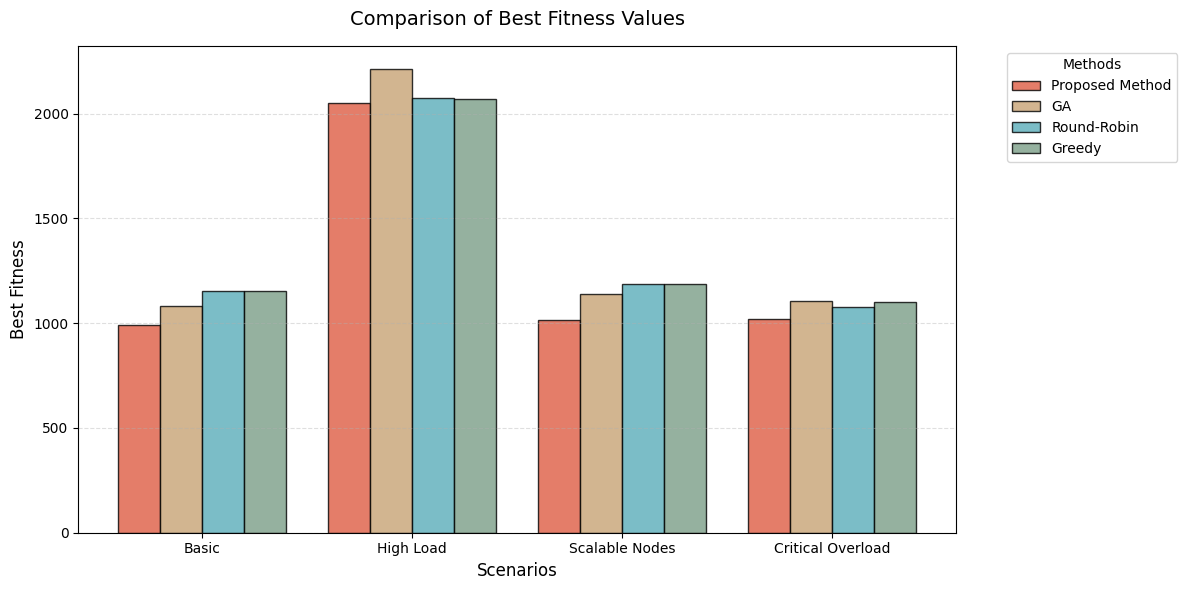

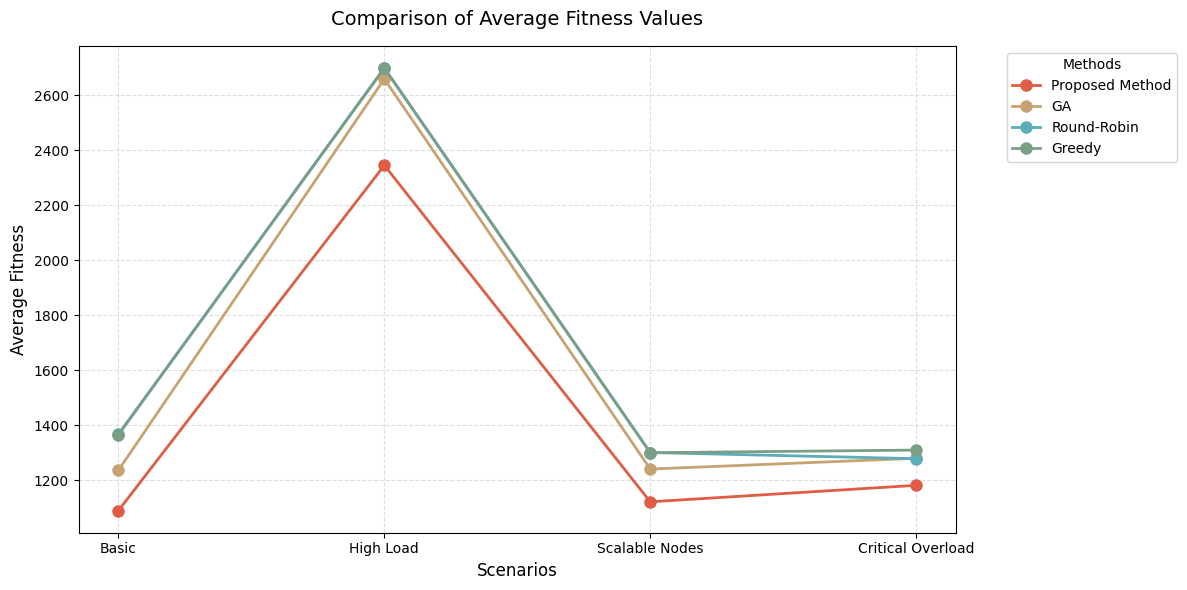

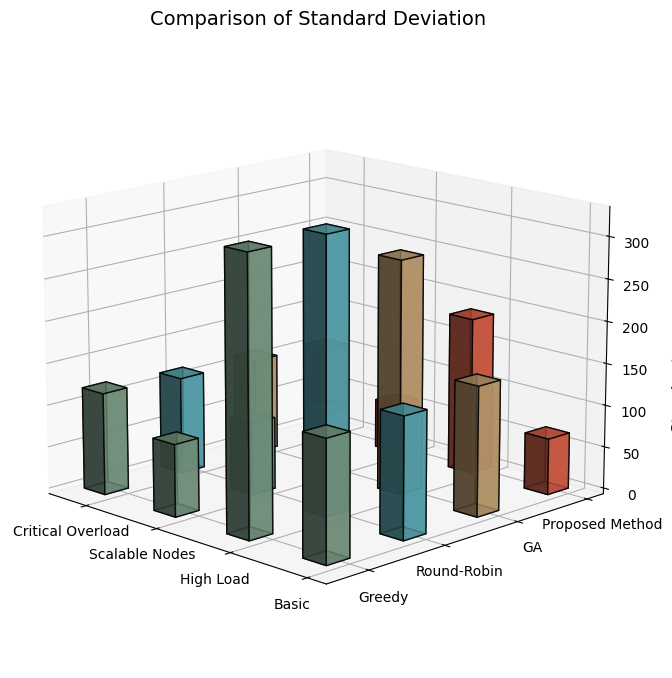

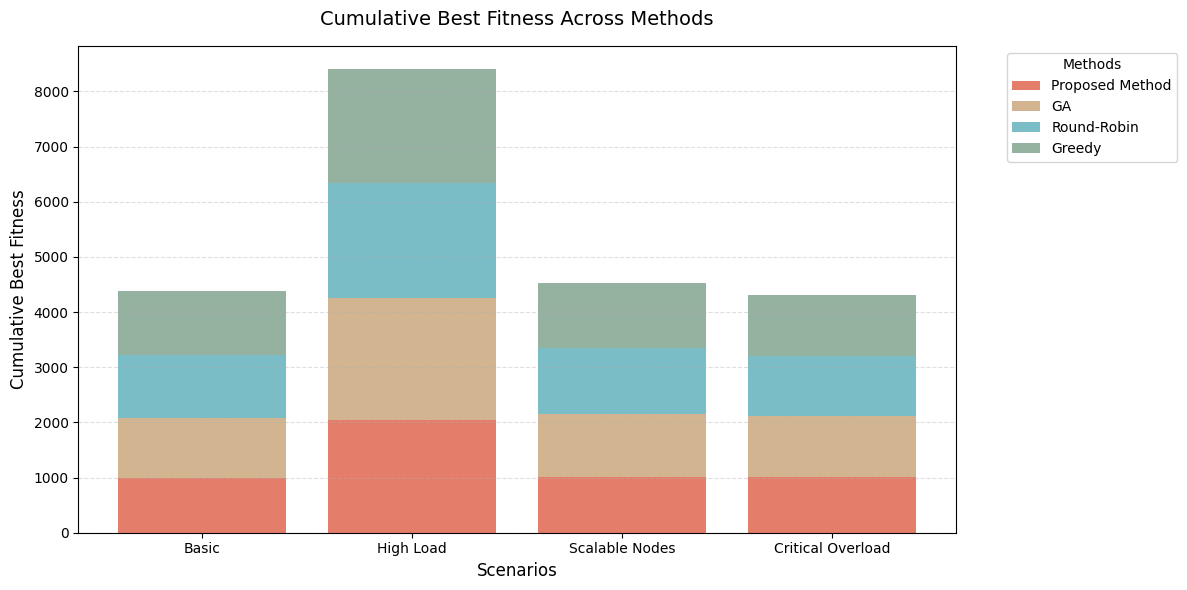

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Dữ liệu mới
scenarios = ["Basic", "High Load", "Scalable Nodes", "Critical Overload"]

best_results = {
    "Proposed Method": [992.21, 2050.09, 1015.00, 1018.11],
    "GA": [1080.69, 2213.12, 1140.18, 1106.88],
    "Round-Robin": [1155.36, 2072.54, 1185.76, 1078.15],
    "Greedy": [1155.25, 2071.67, 1185.41, 1100.45]
}

avg_results = {
    "Proposed Method": [1090.05, 2345.05, 1121.92, 1181.89],
    "GA": [1236.59, 2659.03, 1240.99, 1280.19],
    "Round-Robin": [1367.24, 2698.88, 1301.15, 1278.68],
    "Greedy": [1366.26, 2698.00, 1300.40, 1310.04]
}

std_results = {
    "Proposed Method": [66.68, 186.74, 58.48, 105.10],
    "GA": [153.83, 278.29, 74.05, 113.69],
    "Round-Robin": [143.75, 328.16, 85.06, 115.34],
    "Greedy": [143.57, 328.14, 85.47, 120.94]
}

# Màu sắc thống nhất, thêm màu cho Greedy
colors = {
    "Proposed Method": "#de5d44",
    "GA": "#c7a374",
    "Round-Robin": "#5aadb9",
    "Greedy": "#7b9e87"  # Màu mới cho Greedy
}

# ===========
# BIỂU ĐỒ 1: BEST (Bar chart)
# ===========
plt.figure(figsize=(12, 6))
bar_width = 0.2  # Giảm bar_width để phù hợp với 4 phương pháp
x = np.arange(len(scenarios))

for i, (method, values) in enumerate(best_results.items()):
    plt.bar(x + i*bar_width, values, bar_width, label=method,
            color=colors[method], alpha=0.8, edgecolor='black')

plt.xlabel("Scenarios", fontsize=12)
plt.ylabel("Best Fitness", fontsize=12)
plt.title("Comparison of Best Fitness Values", fontsize=14, pad=15)
plt.xticks(x + bar_width*1.5, scenarios, rotation=0)
plt.legend(title="Methods", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()

# ===========
# BIỂU ĐỒ 2: AVG (Line plot)
# ===========
plt.figure(figsize=(12, 6))

for method, values in avg_results.items():
    plt.plot(scenarios, values, marker="o", markersize=8,
             linewidth=2, label=method, color=colors[method])

plt.xlabel("Scenarios", fontsize=12)
plt.ylabel("Average Fitness", fontsize=12)
plt.title("Comparison of Average Fitness Values", fontsize=14, pad=15)
plt.xticks(rotation=0)
plt.legend(title="Methods", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()

# ===========
# BIỂU ĐỒ 3: STD (3D Bar Chart)
# ===========
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

bar_width = 0.3
x = np.arange(len(scenarios))
y_labels = list(std_results.keys())
y = np.arange(len(y_labels))

xpos, ypos = np.meshgrid(x, y)
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)
dz = np.array([std_results[method][i] for method in y_labels for i in range(len(scenarios))])

# Sử dụng màu sắc nhất quán
colors_3d = [colors[method] for method in y_labels for _ in range(len(scenarios))]
bars = ax.bar3d(xpos, ypos, zpos, bar_width, bar_width, dz,
                color=colors_3d, alpha=0.8, edgecolor='black')

ax.set_xlabel(" ", fontsize=12, labelpad=10)
ax.set_ylabel(" ", fontsize=12, labelpad=10)
ax.set_zlabel("Standard Deviation", fontsize=12, labelpad=10)
ax.set_title("Comparison of Standard Deviation", fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(scenarios, rotation=0)
ax.set_yticks(y)
ax.set_yticklabels(y_labels)
ax.view_init(elev=15, azim=135)

plt.tight_layout()

# ===========
# BIỂU ĐỒ 4: So sánh tổng hợp (Stacked Bar Chart cho Best Fitness)
# ===========
plt.figure(figsize=(12, 6))

bottom = np.zeros(len(scenarios))
for method, values in best_results.items():
    plt.bar(scenarios, values, label=method, color=colors[method], alpha=0.8, bottom=bottom)
    bottom += np.array(values)

plt.xlabel("Scenarios", fontsize=12)
plt.ylabel("Cumulative Best Fitness", fontsize=12)
plt.title("Cumulative Best Fitness Across Methods", fontsize=14, pad=15)
plt.legend(title="Methods", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()

plt.show()

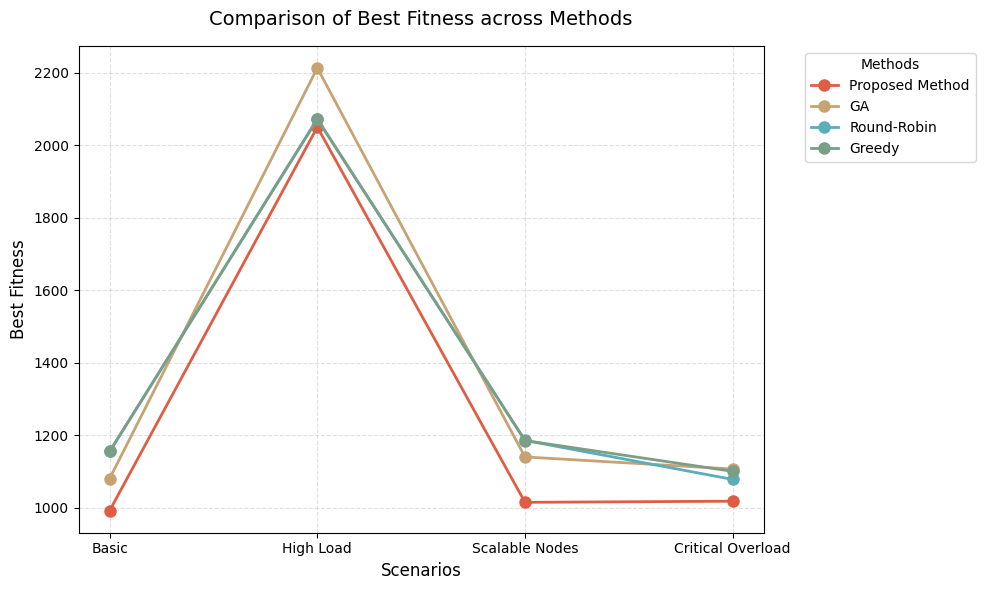

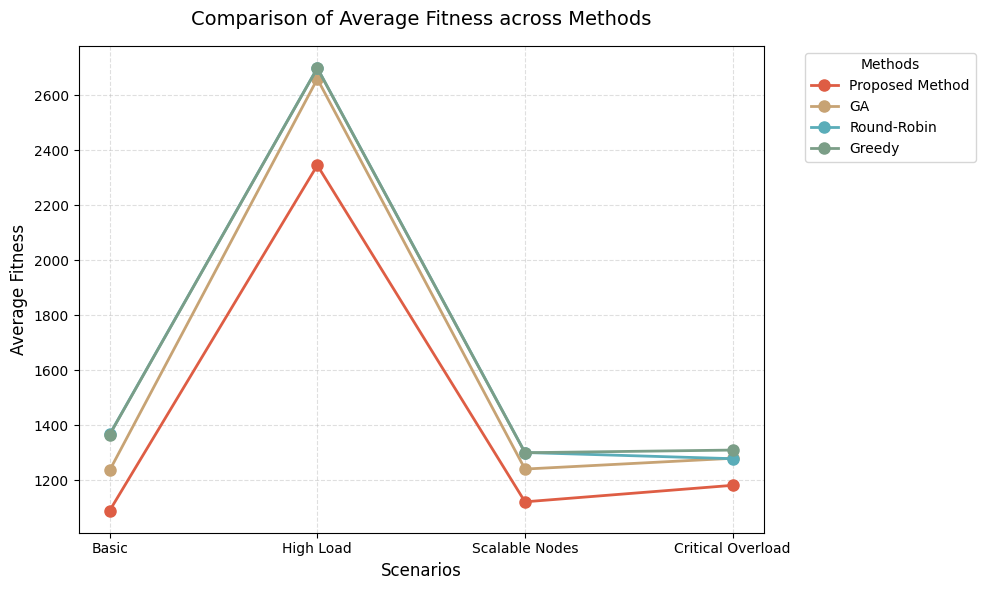

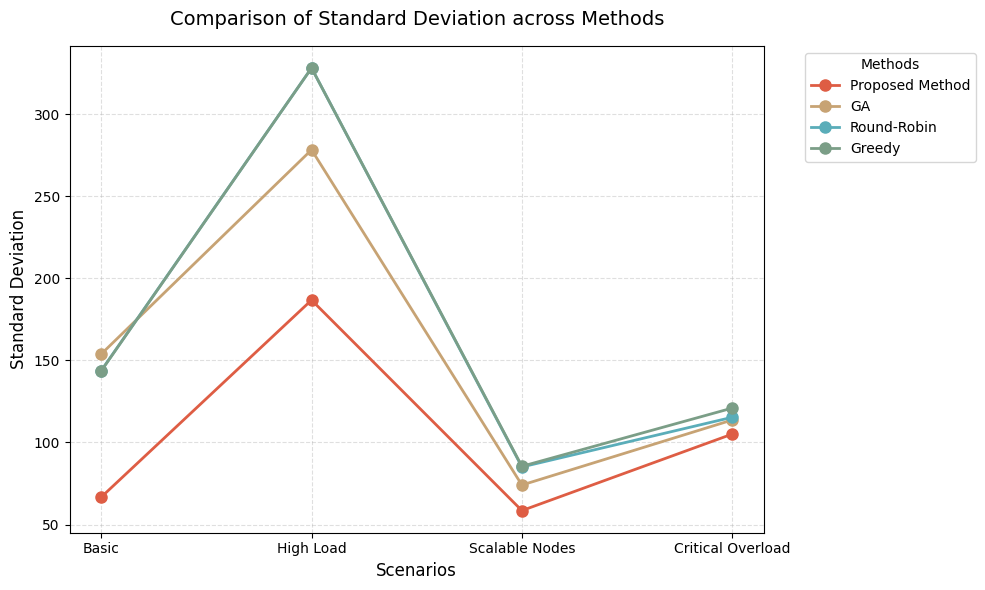

In [22]:
import matplotlib.pyplot as plt

# Dữ liệu
scenarios = ["Basic", "High Load", "Scalable Nodes", "Critical Overload"]

best_results = {
    "Proposed Method": [992.21, 2050.09, 1015.00, 1018.11],
    "GA": [1080.69, 2213.12, 1140.18, 1106.88],
    "Round-Robin": [1155.36, 2072.54, 1185.76, 1078.15],
    "Greedy": [1155.25, 2071.67, 1185.41, 1100.45]
}

avg_results = {
    "Proposed Method": [1090.05, 2345.05, 1121.92, 1181.89],
    "GA": [1236.59, 2659.03, 1240.99, 1280.19],
    "Round-Robin": [1367.24, 2698.88, 1301.15, 1278.68],
    "Greedy": [1366.26, 2698.00, 1300.40, 1310.04]
}

std_results = {
    "Proposed Method": [66.68, 186.74, 58.48, 105.10],
    "GA": [153.83, 278.29, 74.05, 113.69],
    "Round-Robin": [143.75, 328.16, 85.06, 115.34],
    "Greedy": [143.57, 328.14, 85.47, 120.94]
}

# Màu sắc cho từng phương pháp
colors = {
    "Proposed Method": "#de5d44",
    "GA": "#c7a374",
    "Round-Robin": "#5aadb9",
    "Greedy": "#7b9e87"
}

# Danh sách dữ liệu và tiêu chí
data_dicts = [best_results, avg_results, std_results]
metric_titles = ["Best Fitness", "Average Fitness", "Standard Deviation"]

# Vẽ 3 biểu đồ
for data, metric in zip(data_dicts, metric_titles):
    plt.figure(figsize=(10, 6))

    # Vẽ đường cho từng phương pháp
    for method, values in data.items():
        plt.plot(scenarios, values, marker="o", markersize=8,
                 linewidth=2, label=method, color=colors[method])

    # Thiết lập biểu đồ
    plt.xlabel("Scenarios", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.title(f"Comparison of {metric} across Methods", fontsize=14, pad=15)
    plt.xticks(rotation=0)
    plt.legend(title="Methods", loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()

    # Hiển thị biểu đồ
    plt.show()

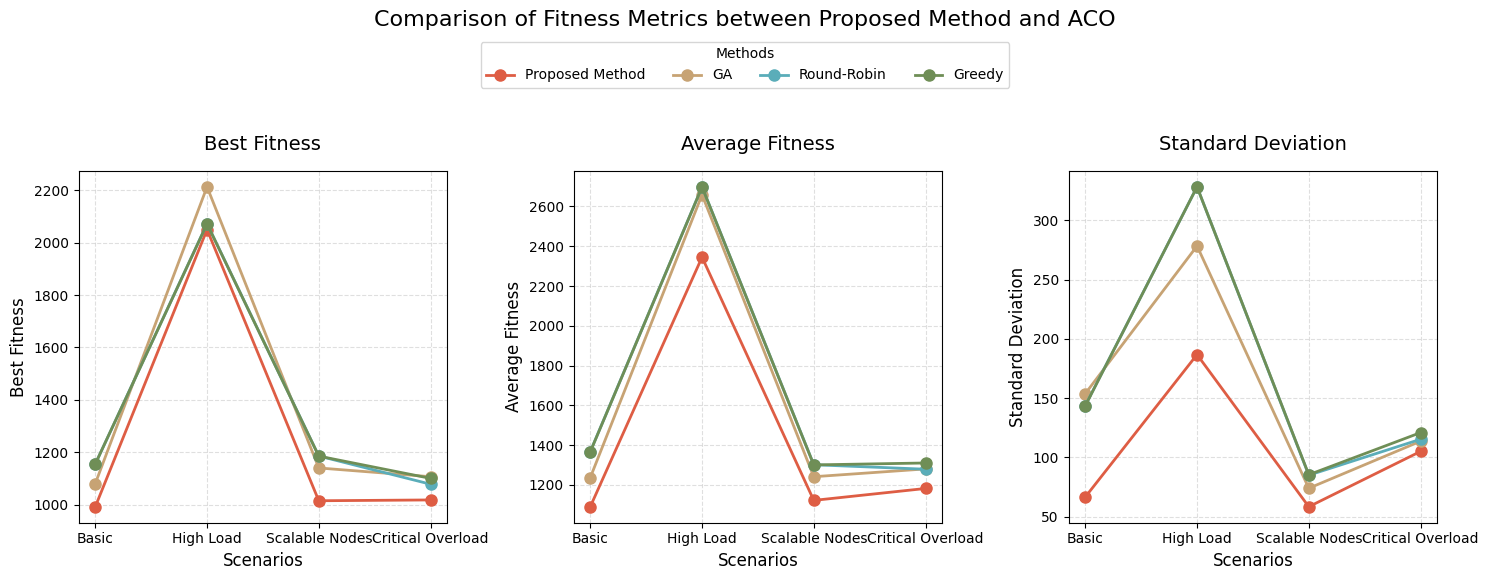

In [29]:
import matplotlib.pyplot as plt

# Dữ liệu
scenarios = ["Basic", "High Load", "Scalable Nodes", "Critical Overload"]

best_results = {
    "Proposed Method": [992.21, 2050.09, 1015.00, 1018.11],
    "GA": [1080.69, 2213.12, 1140.18, 1106.88],
    "Round-Robin": [1155.36, 2072.54, 1185.76, 1078.15],
    "Greedy": [1155.25, 2071.67, 1185.41, 1100.45]
}

avg_results = {
    "Proposed Method": [1090.05, 2345.05, 1121.92, 1181.89],
    "GA": [1236.59, 2659.03, 1240.99, 1280.19],
    "Round-Robin": [1367.24, 2698.88, 1301.15, 1278.68],
    "Greedy": [1366.26, 2698.00, 1300.40, 1310.04]
}

std_results = {
    "Proposed Method": [66.68, 186.74, 58.48, 105.10],
    "GA": [153.83, 278.29, 74.05, 113.69],
    "Round-Robin": [143.75, 328.16, 85.06, 115.34],
    "Greedy": [143.57, 328.14, 85.47, 120.94]
}

# Màu sắc cho từng phương pháp
colors = {
    "Proposed Method": "#de5d44",
    "GA": "#c7a374",
    "Round-Robin": "#5aadb9",
    "Greedy": "#6f8e56"
}

# Danh sách dữ liệu và tiêu chí
data_dicts = [best_results, avg_results, std_results]
metric_titles = ["Best Fitness", "Average Fitness", "Standard Deviation"]

# Tạo một hình với 3 biểu đồ con nằm ngang
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 hàng, 3 cột, kích thước tổng

# Vẽ từng biểu đồ con
for ax, data, metric in zip(axes, data_dicts, metric_titles):
    # Vẽ đường cho từng phương pháp
    for method, values in data.items():
        ax.plot(scenarios, values, marker="o", markersize=8,
                linewidth=2, label=method, color=colors[method])

    # Thiết lập biểu đồ con
    ax.set_xlabel("Scenarios", fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(metric, fontsize=14, pad=15)
    ax.set_xticks(range(len(scenarios)))
    ax.set_xticklabels(scenarios, rotation=0)
    ax.grid(True, linestyle="--", alpha=0.4)

# Thêm chú thích chung ở trên cùng
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Methods", loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.1))

# Thêm tiêu đề tổng
fig.suptitle("Comparison of Fitness Metrics between Proposed Method and ACO", fontsize=16, y=1.15)

# Điều chỉnh bố cục
plt.tight_layout()

# Hiển thị hình
plt.show()

so sánh riêng vói ACO

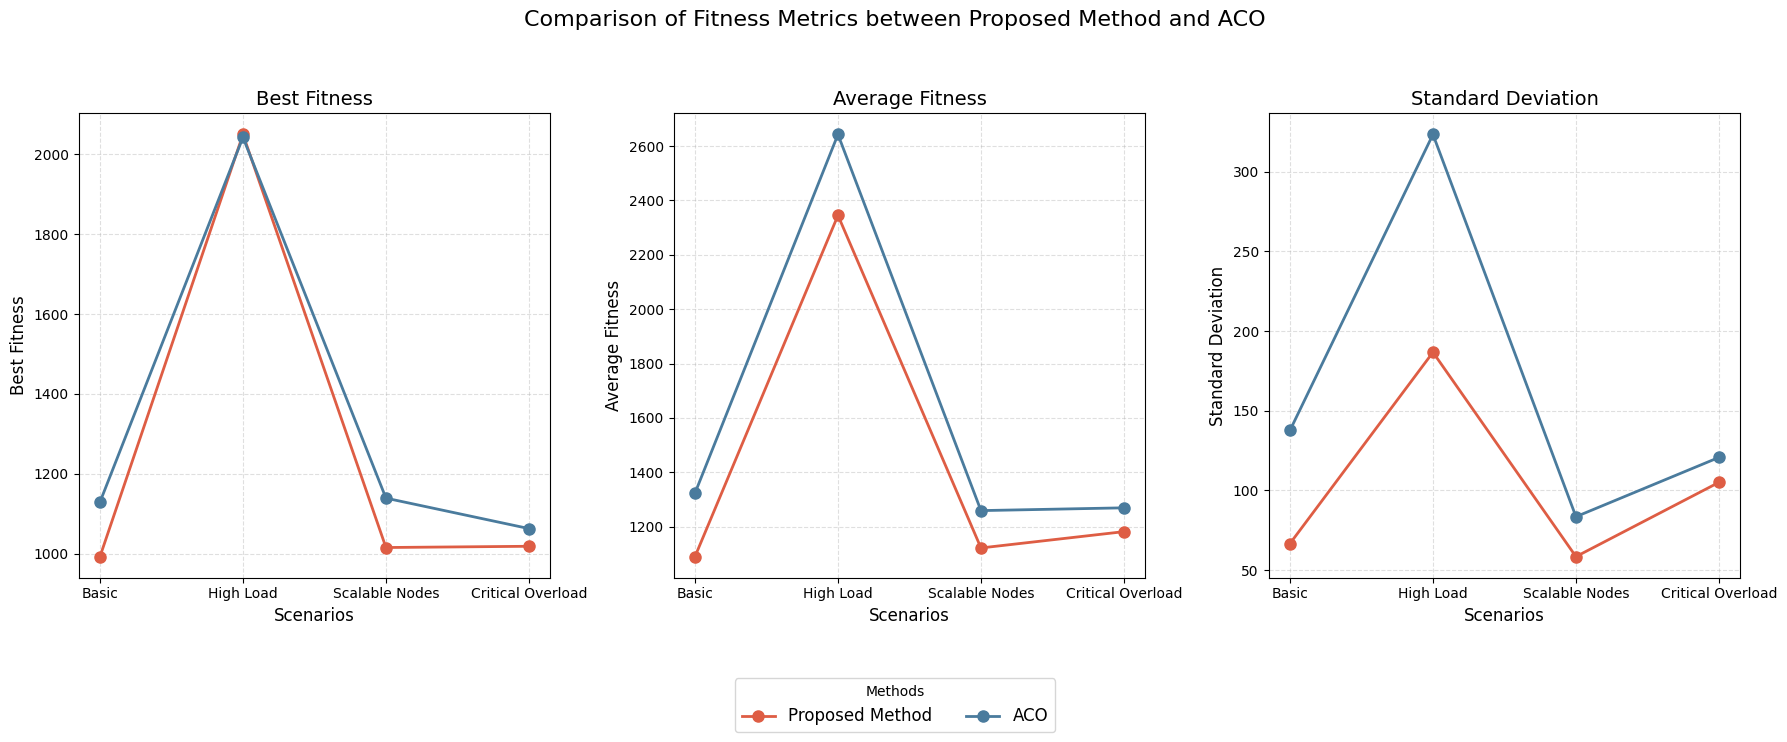

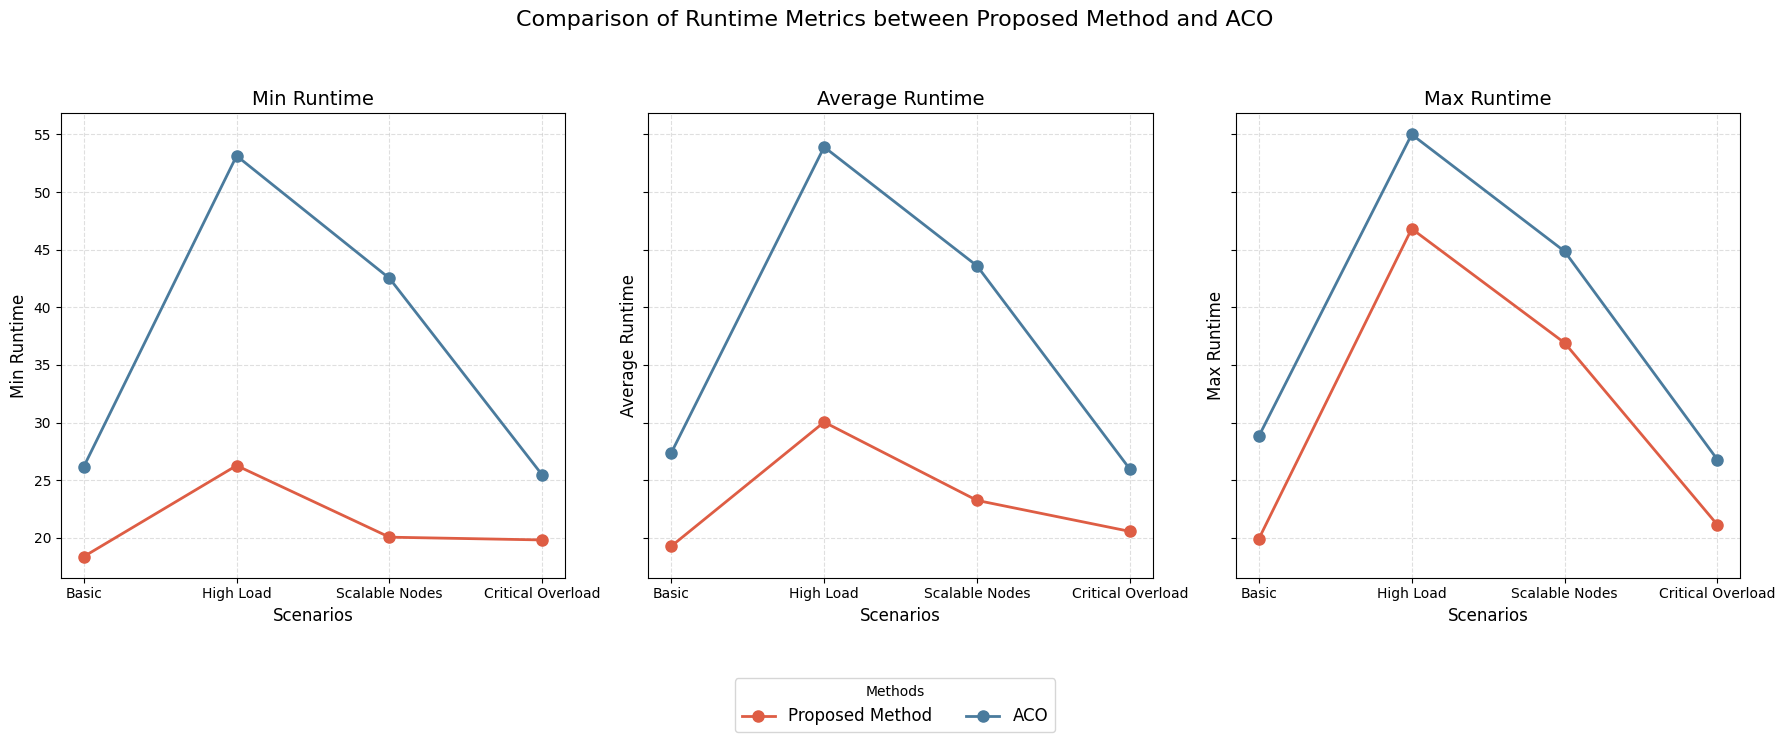

In [20]:
import matplotlib.pyplot as plt

# Dữ liệu
scenarios = ["Basic", "High Load", "Scalable Nodes", "Critical Overload"]

# Proposed Method
proposed_data = {
    "Best Fitness": [992.21, 2050.09, 1015.00, 1018.11],
    "Average Fitness": [1090.05, 2345.05, 1121.92, 1181.89],
    "Standard Deviation": [66.68, 186.74, 58.48, 105.10],
    "Min Runtime": [18.3722, 26.2739, 20.0590, 19.8183],
    "Average Runtime": [19.2744, 30.0432, 23.2498, 20.5594],
    "Max Runtime": [19.9078, 46.8195, 36.9196, 21.1248]
}

# ACO
aco_data = {
    "Best Fitness": [1128.87, 2042.88, 1138.72, 1062.44],
    "Average Fitness": [1323.44, 2642.79, 1259.26, 1269.49],
    "Standard Deviation": [137.70, 323.47, 83.53, 120.75],
    "Min Runtime": [26.1681, 53.1461, 42.5202, 25.4415],
    "Average Runtime": [27.3720, 53.9149, 43.6011, 25.9589],
    "Max Runtime": [28.8114, 55.0042, 44.8612, 26.7823]
}

# Màu sắc
colors = {"Proposed Method": "#de5d44", "ACO": "#4a7b9d"}

# Tiêu chí
metrics_fitness = ["Best Fitness", "Average Fitness", "Standard Deviation"]
metrics_runtime = ["Min Runtime", "Average Runtime", "Max Runtime"]

# Vẽ hình 1: Fitness Metrics (Best Fitness, Average Fitness, Standard Deviation)
fig1, axes1 = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

for i, metric in enumerate(metrics_fitness):
    axes1[i].plot(scenarios, proposed_data[metric], marker="o", markersize=8,
                  linewidth=2, label="Proposed Method", color=colors["Proposed Method"])
    axes1[i].plot(scenarios, aco_data[metric], marker="o", markersize=8,
                  linewidth=2, label="ACO", color=colors["ACO"])

    axes1[i].set_xlabel("Scenarios", fontsize=12)
    axes1[i].set_ylabel(metric, fontsize=12)
    axes1[i].set_title(f"{metric}", fontsize=14)
    axes1[i].set_xticks(range(len(scenarios)))
    axes1[i].set_xticklabels(scenarios, rotation=0)
    axes1[i].grid(True, linestyle="--", alpha=0.4)

# Thêm chú thích chung và tiêu đề cho hình 1
fig1.legend(["Proposed Method", "ACO"], title="Methods", loc='upper center',
            bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=12)
fig1.suptitle("Comparison of Fitness Metrics between Proposed Method and ACO", fontsize=16, y=1.05)
plt.tight_layout()

# Vẽ hình 2: Runtime Metrics (Min Runtime, Average Runtime, Max Runtime)
fig2, axes2 = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, metric in enumerate(metrics_runtime):
    axes2[i].plot(scenarios, proposed_data[metric], marker="o", markersize=8,
                  linewidth=2, label="Proposed Method", color=colors["Proposed Method"])
    axes2[i].plot(scenarios, aco_data[metric], marker="o", markersize=8,
                  linewidth=2, label="ACO", color=colors["ACO"])

    axes2[i].set_xlabel("Scenarios", fontsize=12)
    axes2[i].set_ylabel(metric, fontsize=12)
    axes2[i].set_title(f"{metric}", fontsize=14)
    axes2[i].set_xticks(range(len(scenarios)))
    axes2[i].set_xticklabels(scenarios, rotation=0)
    axes2[i].grid(True, linestyle="--", alpha=0.4)

# Thêm chú thích chung và tiêu đề cho hình 2
fig2.legend(["Proposed Method", "ACO"], title="Methods", loc='upper center',
            bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=12)
fig2.suptitle("Comparison of Runtime Metrics between Proposed Method and ACO", fontsize=16, y=1.05)
plt.tight_layout()

# Hiển thị cả hai hình
plt.show()